## EE 782: Advanced Topics in Machine Learning
### **Assignment 1:** LSTM-based Stock Trading System
> **NAME:** Munish Monga

> **ROLL NO:** 22M2153

### Table of Contents:
1. [Introduction](#introduction)
2. [Importing Libraries](#importing-libraries)

### Introduction <a id="introduction"></a>

### Mounting Google Drive <a id="mounting-google-drive"></a>

In [ ]:
from google.colab import drive                  # Importing drive from google colab
drive.mount('/content/drive')                   # Mounting the drive

### Importing Libraries <a id="importing-libraries"></a>

In [1]:
import pandas as pd                                             # for data handling  
import numpy as np                                              # for numerical computations               
import pathlib as pl                                            # for path handling
import matplotlib.pyplot as plt                                 # for plotting
import random                                                   # for random number generation
import mplfinance as mpl                                        # for candlestick plotting
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # for normalization
import seaborn as sns                                           # for plotting histograms
import torch                                                    # for deep learning functionality
import torch.nn as nn                                           # for LSTM model
from torch.utils.data import Dataset, DataLoader                # for data loading
from tqdm import tqdm                                           # for progress bar

### Hyperparameters <a id="hyperparameters"></a>

In [2]:
batch_size = 128                                                     # batch size for training
random_seed = 42                                                    # for reproducibility
random.seed(random_seed)                                            # set random seed
few_stocks = 4                                                      # used in Q1 to plot few stocks
start_date, end_date = '2020-01-01','2020-02-01'                    # used in Q1c to plot candlesticks chart
device = 'cuda' if torch.cuda.is_available() else 'cpu'             # set device to cuda if available
hidden_dim, num_layers = 32, 1                                      # LSTM model parameters
seq_length = 10                                                     # sequence length for LSTM model  
pred_horizon = 1                                                   # prediction horizon  
predict = 'Close'                                                   # Predict the closing or opening price
epochs = 10                                                         # number of epochs for training
learning_rate = 0.01                                                # learning rate for training
weight_decay = 0.03                                                 # weight decay for regularization
regularize = False                                                  # to regularize the model or not
years_to_keep = 10                                                  # number of years to keep for training

### Q1. Exploring Dataset <a id="exploring-dataset"></a>
- Familiarize yourself with the input data `sp500_tickers_A-D_1min_1pppix.zip`

In [3]:
data_dir = pl.Path('./dataset/sp500_tickers_A-D_1min_1pppix/')             # Setting path to the data directory
companies_list = data_dir.glob('*.txt')                            # Getting the list of all the files in data dir
stocks = [stock.stem.split('_')[0] for stock in companies_list]    # Getting the list of all the companies
print(stocks)                                                      # Printing the name of stocks
print("Total number of stocks:",len(stocks))                       # Printing the total number of stocks

['C', 'AME', 'AZO', 'DNB', 'ADBE', 'ADSK', 'DLTR', 'AVGO', 'DFS', 'CI', 'ANTM', 'ADT', 'ARNC', 'CZR', 'CRM', 'CARR', 'CPB', 'AMBC', 'AN', 'BBY', 'BWA', 'ATVI', 'AMAT', 'ADM', 'D', 'DUK', 'BLK', 'CINF', 'COP', 'CMCSA', 'DISCK', 'CHKP', 'ALK', 'CE', 'CMS', 'ALTR', 'BMRN', 'CAH', 'COF', 'DPZ', 'DLX', 'CNP', 'CAR', 'CBRE', 'ACN', 'CCU', 'CNC', 'ATO', 'CSX', 'BIIB', 'COOP', 'ANET', 'ARE', 'ADI', 'CAG', 'AMP', 'COTY', 'CSCO', 'CTVA', 'BIDU', 'DXC', 'APTV', 'CDW', 'AON', 'CTLT', 'APD', 'CC', 'DDS', 'BF.B', 'DIS', 'CVS', 'CNX', 'AINV', 'ABT', 'AMG', 'ANF', 'BXP', 'DTE', 'BAX', 'CTXS', 'DVN', 'CERN', 'AIV', 'DE', 'CBH', 'CL', 'BIG', 'BTU', 'CHTR', 'DISCA', 'AEE', 'CCL', 'CAT', 'CFG', 'BA', 'AMGN', 'CDNS', 'CTSH', 'CLX', 'BEN', 'BKNG', 'ASH', 'CMA', 'BR', 'DXCM', 'BDX', 'AMZN', 'ABC', 'DVA', 'DOW', 'CHD', 'ASO', 'ADS', 'BSX', 'CF', 'ATGE', 'BUD', 'CHRW', 'DOV', 'BRK.B', 'BK', 'AEP', 'ALL', 'AAPL', 'AIG', 'ATI', 'AXP', 'CVX', 'CBOE', 'ACV', 'DAN', 'DLR', 'DD', 'AIZ', 'ANSS', 'BBBY', 'CDAY', 'AMD'

Let us randomly select few stocks for Q1, seed is kept as 42 for reproducibility.

In [4]:
random_stocks = random.sample(stocks, few_stocks)                 # Selecting few random stocks
print("Randomly Selected Stocks:",random_stocks)                  # Printing the selected stocks

Randomly Selected Stocks: ['ABBV', 'COP', 'DLTR', 'CCI']


Columns names are refered from [[1]](#ref1)

In [17]:
def create_df_dict(stocks):
    """
    Creates a dictionary of dataframes for each stock.
    
    Parameters:
    - stocks (list): A list of stock names.
    
    Returns:
    - df_dict (dict): A dictionary with stock names as keys and their corresponding dataframes as values.
    """
    data_dir = pl.Path('./dataset/sp500_tickers_A-D_1min_1pppix/') 
    df_dict = {}
    for stock in stocks:
        df = pd.read_csv(data_dir / f'{stock}_1min.txt', sep=',', header=None) # Reading the data
        df.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']    # Naming the columns (see reference [1])
        df_dict[stock] = df
    return df_dict

In [6]:
random_stock_dfs_dict = create_df_dict(random_stocks)       # Creating the dataframes dictionary for these random stocks
for stock, df in random_stock_dfs_dict.items():
    print(f"Stock: {stock}, Shape: {df.shape}")            # Printing the shape of each dataframe

Stock: ABBV, Shape: (944746, 6)
Stock: COP, Shape: (1879504, 6)
Stock: DLTR, Shape: (1469385, 6)
Stock: CCI, Shape: (1649392, 6)


In [16]:
print("Stock:",random_stocks[0])                          # Printing the name of first random stock
random_stock_dfs_dict[random_stocks[0]]                   # Printing the dataframe of first random stock

Stock: ABBV


,DateTime,Open,High,Low,Close,Volume
0,2013-01-02 08:57:00,24.2381,24.2381,24.2381,24.2381,217
1,2013-01-02 09:07:00,23.6098,23.6098,23.6098,23.6098,200
2,2013-01-02 09:08:00,23.6303,23.6303,23.6303,23.6303,100
3,2013-01-02 09:19:00,23.6986,23.6986,23.6986,23.6986,100
4,2013-01-02 09:29:00,23.6713,23.7054,23.6440,23.6440,1800
...,...,...,...,...,...,...
944741,2022-02-25 18:28:00,149.6000,149.6000,149.6000,149.6000,988
944742,2022-02-25 18:30:00,149.5400,149.5400,149.5400,149.5400,0
944743,2022-02-25 18:46:00,149.5400,149.5400,149.5400,149.5400,200
944744,2022-02-25 19:00:00,149.5400,149.5400,149.5400,149.5400,0


In [8]:
print("Stock:",random_stocks[0])                          # Printing the first random stock
random_stock_dfs_dict[random_stocks[0]].info()                 # Printing the info of the first random stock                                             

Stock: ABBV
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944746 entries, 0 to 944745
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   DateTime  944746 non-null  object 
 1   Open      944746 non-null  float64
 2   High      944746 non-null  float64
 3   Low       944746 non-null  float64
 4   Close     944746 non-null  float64
 5   Volume    944746 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 43.2+ MB


In [9]:
print("Stock:",random_stocks[0])                          # Printing the first random stock
random_stock_dfs_dict[random_stocks[0]].describe()             # Printing the description of the first random stock

Stock: ABBV


,Open,High,Low,Close,Volume
count,944746.000000,944746.000000,944746.000000,944746.000000,9.447460e+05
mean,64.910379,64.936936,64.883632,64.910277,1.680320e+04
std,26.433196,26.442576,26.423622,26.433252,6.605120e+04
min,22.776600,22.824400,22.762900,22.769800,0.000000e+00
25%,43.964825,43.984400,43.945200,43.962600,4.668000e+03
50%,58.418950,58.436750,58.399100,58.419600,8.610000e+03
75%,81.054225,81.089500,81.015100,81.053775,1.600000e+04
max,150.350000,150.360000,150.290000,150.350000,1.305539e+07


#### Data Preprocessing <a id="data-preprocessing"></a>

In [18]:
def get_latest_df_dict(df_dict, years_to_keep):
    """
    Filters each dataframe to keep only the latest data based on a given number of years.
    
    Parameters:
    - df_dict (dict): Dictionary containing stock dataframes.
    - years_to_keep (int, optional): Number of years of data to retain. Defaults to 10.
    
    Returns:
    - latest_df_dict (dict): Dictionary containing the latest data for each stock.
    """
    latest_df_dict = {}
    # df_dict_temp = separate_datetime_dfs_dict(df_dict)        # Ensure that the DateTime column is converted to Date and Time columns
    for stock, df in df_dict.items():
        df['DateTime'] = pd.to_datetime(df['DateTime'])       # Convert to datetime type
        latest_df = df[df['DateTime'] >= df['DateTime'].max() - pd.DateOffset(years=years_to_keep)]
        latest_df_dict[stock] = latest_df
    
    return latest_df_dict

In [19]:
latest_random_stock_dfs_dict = get_latest_df_dict(random_stock_dfs_dict, years_to_keep) # Getting the latest data for each stock

In [12]:
def process_df_dict(latest_df_dict):
    """
    Processes the stock market data to exclude data outside trading hours and clean missing minutes or holidays.
    
    Parameters:
    - latest_df_dict (dict): Dictionary containing the latest data for each stock.
    
    Returns:
    - processed_df_dict (dict): Dictionary containing the processed data for each stock.
    """
    processed_df_dict = {}
    
    # Define trading hours
    trading_start = pd.to_datetime("9:30").time()           # 9:30 AM
    trading_end = pd.to_datetime("16:00").time()            # 4:00 PM
    
    for stock, df in latest_df_dict.items():
        # Ensure the DateTime column is of datetime type
        df['DateTime'] = pd.to_datetime(df['DateTime'])
        
        # Exclude data outside of trading hours
        df = df[df['DateTime'].dt.time.between(trading_start, trading_end)]
        
        # Exclude data with missing minutes or days with holidays (assuming very low volume means holiday)
        volume_threshold = df['Volume'].quantile(0.05)     
        df = df[df['Volume'] > volume_threshold]
        
        processed_df_dict[stock] = df
        
    return processed_df_dict

In [13]:
processed_random_stock_dfs_dict = process_df_dict(random_stock_dfs_dict) # Processing the random stock dataframes

In [15]:
print("Stock:",random_stocks[0])                          # Printing the first random stock
processed_random_stock_dfs_dict[random_stocks[0]]         # Printing the first random stock

Stock: ABBV


,DateTime,Open,High,Low,Close,Volume
5,2013-01-02 09:30:00,23.8488,23.8488,23.4937,23.7396,120336
6,2013-01-02 09:31:00,23.7396,23.8352,23.6713,23.6713,19199
7,2013-01-02 09:32:00,23.6303,23.6576,23.5962,23.6405,13518
8,2013-01-02 09:33:00,23.6440,23.6508,23.5620,23.6303,6823
9,2013-01-02 09:34:00,23.6371,23.6884,23.6303,23.6440,32448
...,...,...,...,...,...,...
944725,2022-02-25 15:55:00,149.2350,149.3800,149.2200,149.3300,23369
944726,2022-02-25 15:56:00,149.3300,149.3800,149.2500,149.3450,44299
944727,2022-02-25 15:57:00,149.3500,149.4200,149.2900,149.4200,36907
944728,2022-02-25 15:58:00,149.4000,149.4900,149.3800,149.4700,62290


### Q1a. Plotting minute-by-minute closing price series of few stocks. <a id="q1a"></a>
- Plot the minute-by-minute closing price series of few stocks


To illustrate minute-by-minute closing price series better, I have plotted few stocks on a random date that is common to these stocks.

In [ ]:
def separate_datetime_dfs_dict(df_dict):
    """
    Separates the 'DateTime' column of each dataframe into separate 'Date' and 'Time' columns.
    
    Parameters:
    - df_dict (dict): Dictionary containing stock dataframes.
    
    Returns:
    - converted_dict (dict): Updated dictionary with separated 'Date' and 'Time' columns.
    """
    converted_dict = {}
    for stock, df in df_dict.items():
        df['DateTime'] = pd.to_datetime(df['DateTime'])
        df['Date'] = df['DateTime'].dt.date
        df['Time'] = df['DateTime'].dt.time
        converted_dict[stock] = df
    return converted_dict

In [ ]:
random_stock_dfs_dict = separate_datetime_dfs_dict(random_stock_dfs_dict) # Converting the DateTime column to Date and Time columns
print("Stock:",random_stocks[0])                          # Printing the first random stock
random_stock_dfs_dict[random_stocks[0]].head()                 # Printing the first 5 rows of the first random stock

Stock: ABBV


,DateTime,Open,High,Low,Close,Volume,Date,Time
0,2013-01-02 08:57:00,24.2381,24.2381,24.2381,24.2381,217,2013-01-02,08:57:00
1,2013-01-02 09:07:00,23.6098,23.6098,23.6098,23.6098,200,2013-01-02,09:07:00
2,2013-01-02 09:08:00,23.6303,23.6303,23.6303,23.6303,100,2013-01-02,09:08:00
3,2013-01-02 09:19:00,23.6986,23.6986,23.6986,23.6986,100,2013-01-02,09:19:00
4,2013-01-02 09:29:00,23.6713,23.7054,23.6440,23.6440,1800,2013-01-02,09:29:00


In [ ]:
def getrandomdate(dfs_dict):
    dfs_dict = separate_datetime_dfs_dict(dfs_dict)           # Ensure that the DateTime column is converted to Date and Time columns
    dates = []
    for stock in dfs_dict:
        dates.append(dfs_dict[stock]['Date'].unique().tolist())
    common_dates = set(dates[0]).intersection(*dates[1:])   # Getting the common dates
    random_date = random.choice(list(common_dates))         # Selecting a random date
    return random_date

In [ ]:
random_date = getrandomdate(random_stock_dfs_dict)          # Getting a random date
print("Randomly Selected Date:",random_date)                           # Printing the random date

Randomly Selected Date: 2015-12-02


In [ ]:
def filter_dfs_by_date(dfs_dict, date):
    date = pd.to_datetime(date).date()
    dfs_dict = separate_datetime_dfs_dict(dfs_dict)        # Ensure that the DateTime column is converted to Date and Time columns
    filtered_dfs_dict = {}
    for stock, df in dfs_dict.items():
        filtered_df = df[df['Date'] == date]
        filtered_dfs_dict[stock] = filtered_df
    return filtered_dfs_dict

In [ ]:
filtered_dfs_dict = filter_dfs_by_date(random_stock_dfs_dict, random_date) # Filtering the dfs by the random date
print("Stock:",random_stocks[0])                          # Printing the first random stock
filtered_dfs_dict[random_stocks[0]].head()                                           # Printing the first 5 rows of the first random stock

Stock: ABBV


,DateTime,Open,High,Low,Close,Volume,Date,Time
295234,2015-12-02 09:05:00,44.9281,44.9281,44.9281,44.9281,1000,2015-12-02,09:05:00
295235,2015-12-02 09:16:00,44.6934,44.6934,44.6934,44.6934,500,2015-12-02,09:16:00
295236,2015-12-02 09:30:00,44.8070,44.8600,44.7010,44.7918,65843,2015-12-02,09:30:00
295237,2015-12-02 09:31:00,44.7578,44.9054,44.7313,44.8297,11168,2015-12-02,09:31:00
295238,2015-12-02 09:32:00,44.8411,44.8676,44.7767,44.8070,5582,2015-12-02,09:32:00


In [ ]:
def plot_minute_by_minute(dfs_dict, date):
    filtered_dfs_dict = filter_dfs_by_date(dfs_dict, date) # Filtering the dfs by the date
    stocks = list(filtered_dfs_dict.keys())
    n_stocks = len(stocks)
    nrows = (n_stocks + 1) // 2  # Calculate the number of rows needed for the given stocks

    # Initialize the subplots with 2 columns
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 5 * nrows))
    
    # Flatten the axes for easy iteration, and then iterate only over the needed number of axes for the given stocks
    axes = axes.ravel()

    # Plot the data for each stock in stocks
    for i, stock in enumerate(stocks):
        ax = axes[i]
        
        # Filter data for the date
        data_for_day = filtered_dfs_dict[stock]
        
        # Plot the data using 'Time' for the x-axis and 'Close' for the y-axis
        ax.plot(data_for_day['Time'].astype(str), data_for_day['Close'], label=f'{stock} Closing Price')
        
        # Set titles and labels
        ax.set_title(f'{stock} Minute-by-Minute Closing Price Series on {date}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Closing Price')
        ax.legend()
        ax.grid(True)
        
        # Adjust the x-axis for better readability
        ax.xaxis.set_major_locator(plt.MaxNLocator(20))
        ax.xaxis.set_tick_params(rotation=45)

    # If the number of stocks is odd, remove the last unused subplot
    if n_stocks % 2 == 1:
        fig.delaxes(axes[-1])

    plt.tight_layout()
    plt.show()

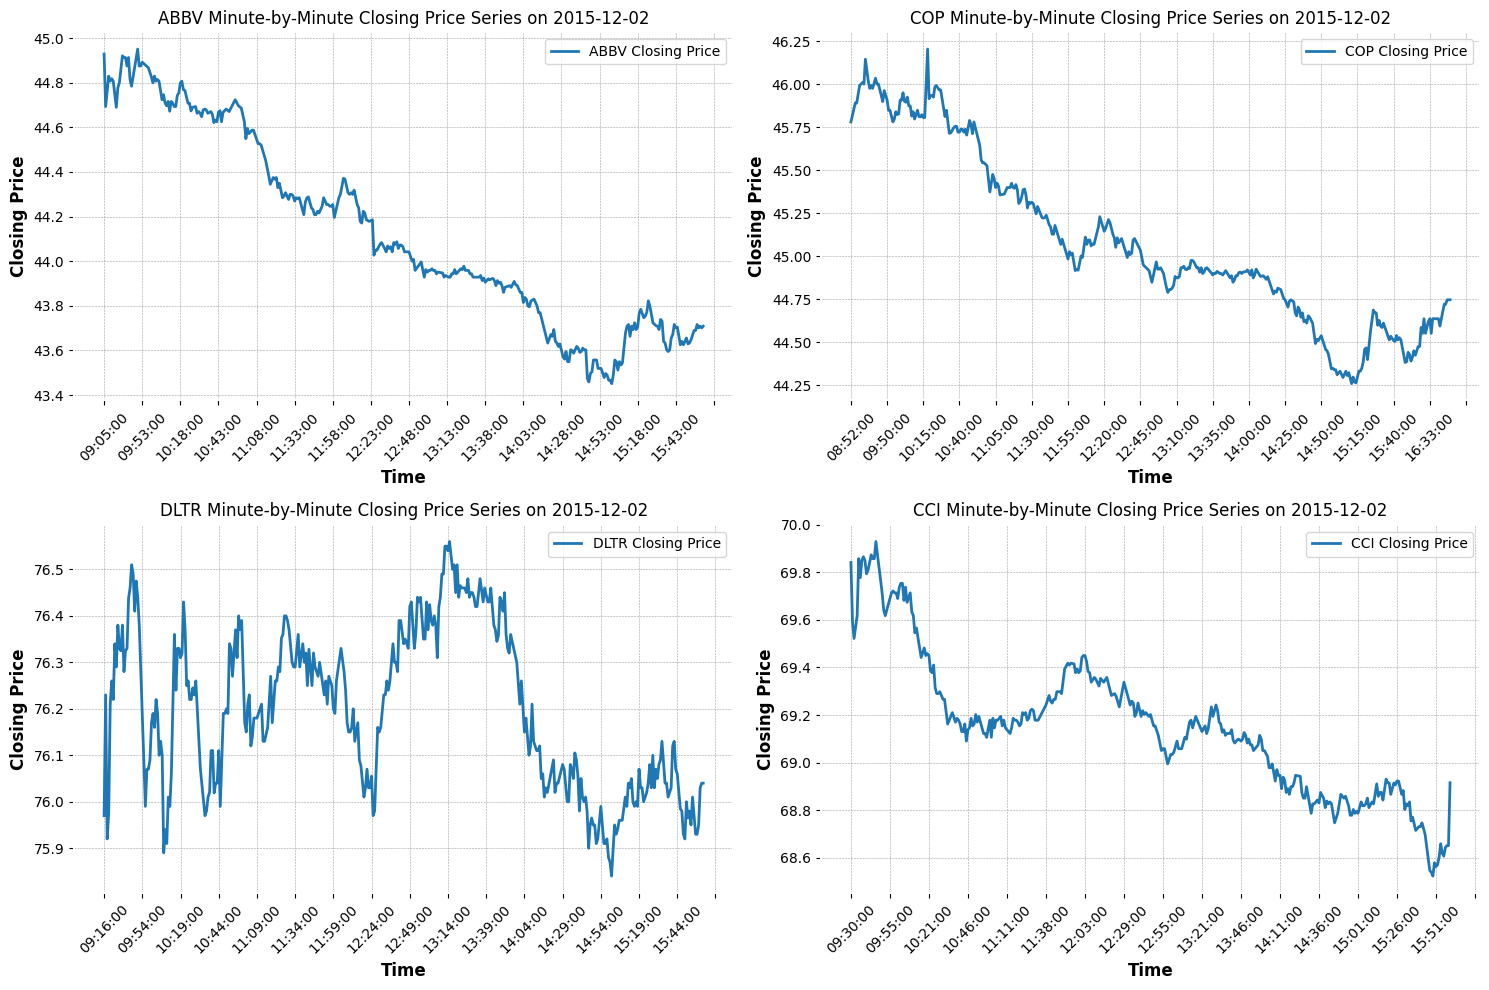

In [ ]:
plot_minute_by_minute(random_stock_dfs_dict, random_date)

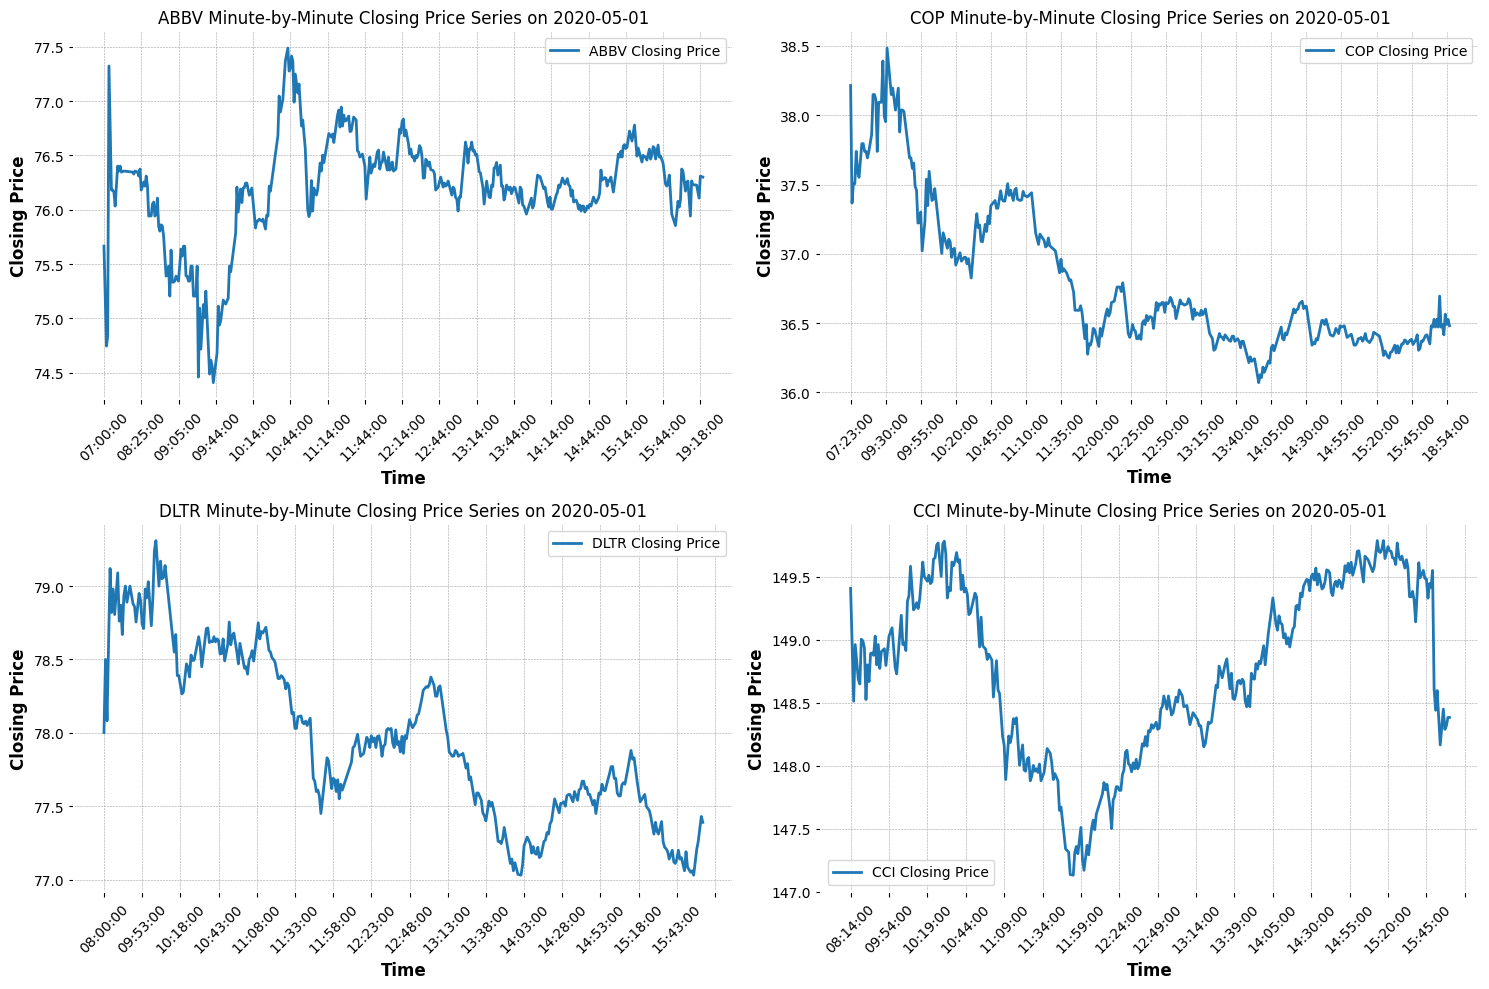

In [ ]:
plot_minute_by_minute(random_stock_dfs_dict, '2020-05-01')

### Q1b. Plotting day-by-day closing price series of a few stocks <a id="q1b"></a>
- Plot the day-by-day closing price series of a few stocks

In [ ]:
def plot_day_by_day_CP(dfs_dict, combine_plots):
    dfs_dict = separate_datetime_dfs_dict(dfs_dict)     # Ensure that the DateTime column is converted to Date and Time columns
    stocks = list(dfs_dict.keys())
    n_stocks = len(stocks)
    
    if combine_plots:                           # If combine_plots is True, plot all the stocks in a single plot
        fig, ax = plt.subplots(figsize=(10, 6))
        
        for stock in stocks:
            ax.plot(dfs_dict[stock]['Date'], dfs_dict[stock]['Close'], label=f'{stock} Closing Price')
        
        ax.set_title('Day-by-Day Closing Price Series')
        ax.set_xlabel('Date')
        ax.set_ylabel('Closing Price')
        ax.legend()
        ax.grid(True)
        ax.xaxis.set_major_locator(plt.MaxNLocator(20))
        ax.xaxis.set_tick_params(rotation=45)
        
        plt.tight_layout()
        plt.show()
    else:
        nrows = (n_stocks + 1) // 2  # Calculate the number of rows needed for the given stocks

        # Initialize the subplots with 2 columns
        fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 5 * nrows))
        
        # Flatten the axes for easy iteration, and then iterate only over the needed number of axes for the given stocks
        axes = axes.ravel()

        # Plot the data for each stock in stocks
        for i, stock in enumerate(stocks):
            ax = axes[i]
            
            # Plot the data using 'Date' for the x-axis and 'Close' for the y-axis
            ax.plot(dfs_dict[stock]['Date'], dfs_dict[stock]['Close'], label=f'{stock} Closing Price')
            
            # Set titles and labels
            ax.set_title(f'{stock} Day-by-Day Closing Price Series')
            ax.set_xlabel('Date')
            ax.set_ylabel('Closing Price')
            ax.legend()
            ax.grid(True)
            
            # Adjust the x-axis for better readability
            ax.xaxis.set_major_locator(plt.MaxNLocator(20))
            ax.xaxis.set_tick_params(rotation=45)

        # If the number of stocks is odd, remove the last unused subplot
        if n_stocks % 2 == 1:
            fig.delaxes(axes[-1])

        plt.tight_layout()
        plt.show()

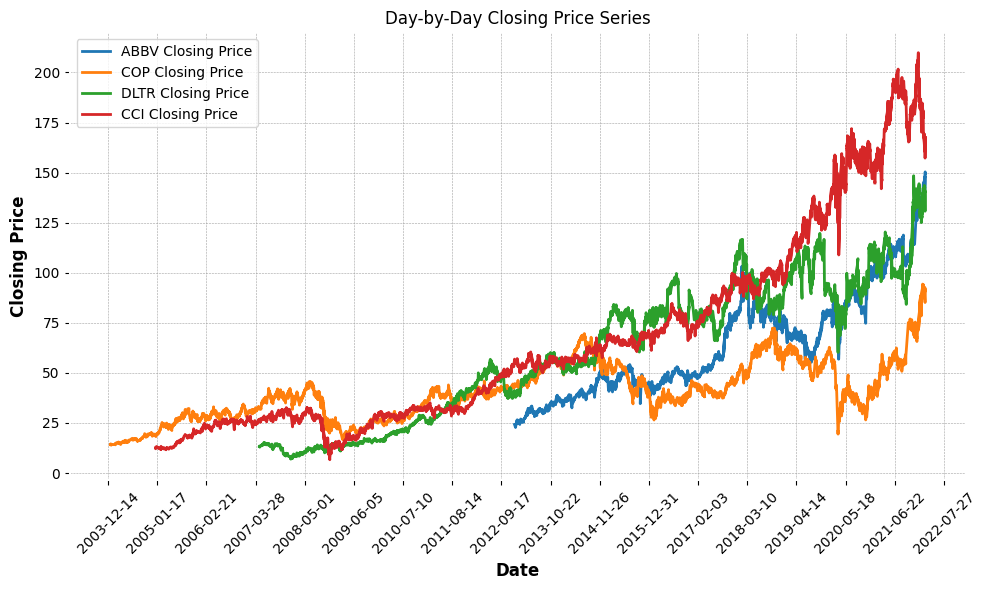

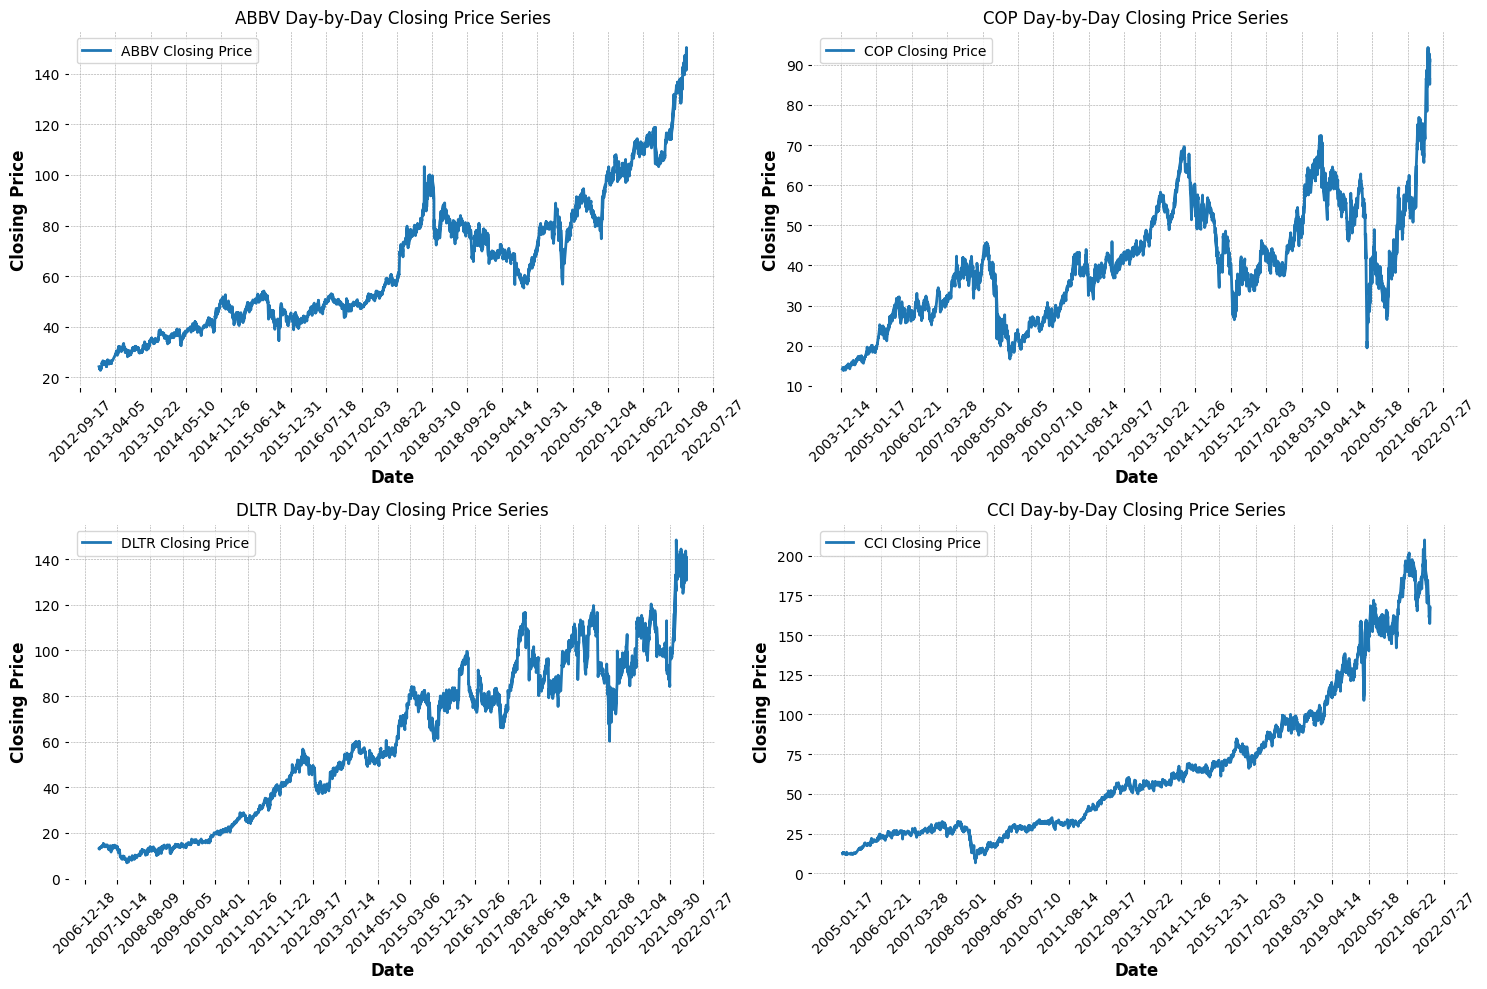

In [ ]:
plot_day_by_day_CP(random_stock_dfs_dict, combine_plots=True)  # Plotting all the stocks in a single plot
plot_day_by_day_CP(random_stock_dfs_dict, combine_plots=False) # Plotting each stock in a separate plot

### Q1c. Plotting candlestick chart <a id="q1c"></a>
- Plot a complete candlestick chart with volume on secondary y-axis for a few stocks with a
time period of your choice

Resampling stock data to daily frequency to plot for better visualization of candlestick chart. `Start_Date` and `End_Date` for the time period are specified in the [hyperparameters](#hyperparameters) section. Note that increasing the time period will lead to more data points and a more cluttered candlestick chart. Hence, the time period is kept to one month.

In [ ]:
def resample_dfs(dfs_dict, start_date, end_date, freq):
    resampled_dfs_dict = {}
    
    for stock, data in dfs_dict.items():
        data['DateTime'] = pd.to_datetime(data['DateTime'])  # Convert to datetime type
        
        resampled_data = data.resample(freq, on='DateTime').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        })
        
        # Drop any rows with NaN values (this can happen if there's no data for a particular day)
        resampled_data = resampled_data.dropna()
        resampled_dfs_dict[stock] = resampled_data

    # Convert start_date and end_date to datetime objects
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Filter the resampled data based on the start and end date
    for stock, data in resampled_dfs_dict.items():
        mask = (data.index >= start_date) & (data.index <= end_date)
        resampled_dfs_dict[stock] = data[mask]

    return resampled_dfs_dict

In [ ]:
resampled_dfs_dict = resample_dfs(random_stock_dfs_dict, start_date, end_date, freq='D')
print(f"Resampled data for {random_stocks[0]} from {start_date} to {end_date}:")
print(resampled_dfs_dict[random_stocks[0]])

Resampled data for ABBV from 2020-01-01 to 2020-02-01:
               Open     High      Low    Close    Volume
DateTime                                                
2020-01-02  79.7436  80.2984  79.2067  80.0836   4193923
2020-01-03  79.4214  79.9942  78.6608  79.6452   4856552
2020-01-06  78.7950  80.2000  78.7324  79.8241   5379530
2020-01-07  80.2358  80.5087  78.4818  78.4818   6095112
2020-01-08  79.5467  80.5937  78.7503  80.2268   6369883
2020-01-09  80.5400  80.9338  79.6899  80.9338   6317827
2020-01-10  80.8264  80.9875  79.4930  79.9673   7210872
2020-01-13  80.0747  80.3611  78.6742  79.5288   8058298
2020-01-14  79.4786  80.2087  78.6986  79.9140   7196669
2020-01-15  80.2586  81.5193  79.6782  80.9570   7078565
2020-01-16  81.3198  81.4422  80.6486  81.1384   6040154
2020-01-17  80.9570  81.3552  79.6237  79.8142   8535174
2020-01-21  79.8414  80.4799  79.4197  79.8051  10442168
2020-01-22  79.8777  80.1861  78.9435  78.9979   5369840
2020-01-23  79.3335  79.3335  77.

In [ ]:
def plot_candlesticks(dfs_dict, start_date, end_date, freq):
    resampled_dfs_dict = resample_dfs(dfs_dict, start_date, end_date, freq=freq)
    for stock, df in resampled_dfs_dict.items():
        # Create a custom plot configuration for the volume (to be shown on a secondary y-axis)
        volume_plt = [mpl.make_addplot(df['Volume'], panel=1, secondary_y='auto', color='g')]

        # Plot the candlestick chart
        mpl.plot(df, 
                 type='candle',
                 style='charles',
                 title=f'{stock} Candlestick Chart ({start_date} to {end_date})',
                 ylabel='Price',
                 addplot=volume_plt,
                 volume=True,
                 show_nontrading=True,      # to show gap for non trading days
                 figsize=(10, 5))

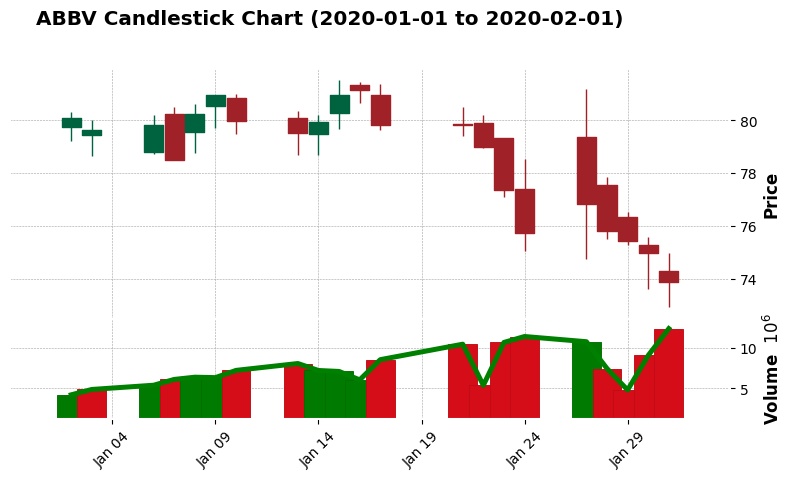

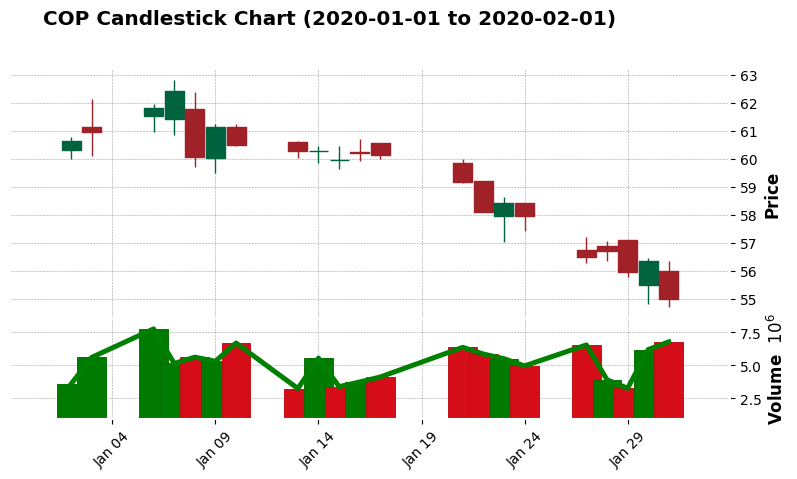

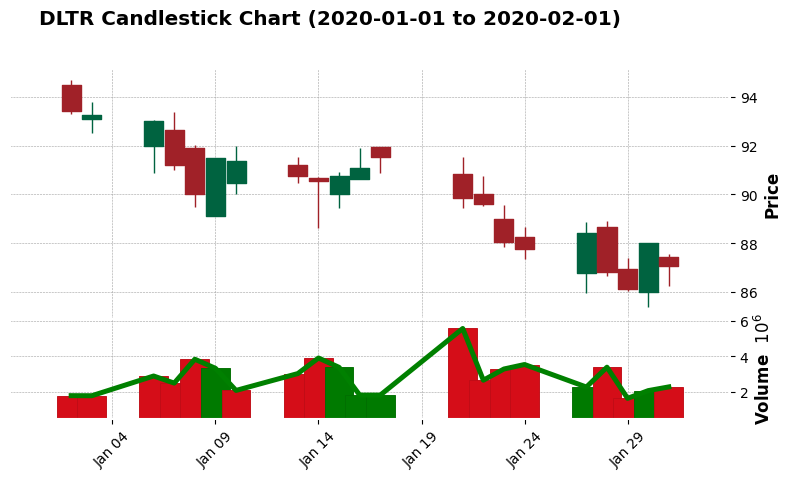

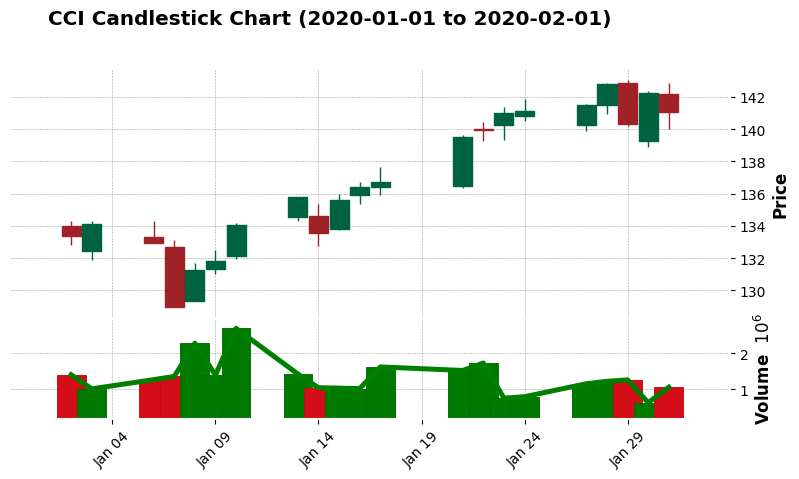

In [ ]:
plot_candlesticks(random_stock_dfs_dict, start_date, end_date, freq = 'D')

### Q1d. Observations <a id="q1d"></a>
- Note down your observations, e.g. are there any data issues, unexpected jumps,
unexpected missing data etc.


Let us compare the stock prices of the two companies, namely, `Apple` and `Amazon`. We will plot the closing price of the two companies on the same graph.

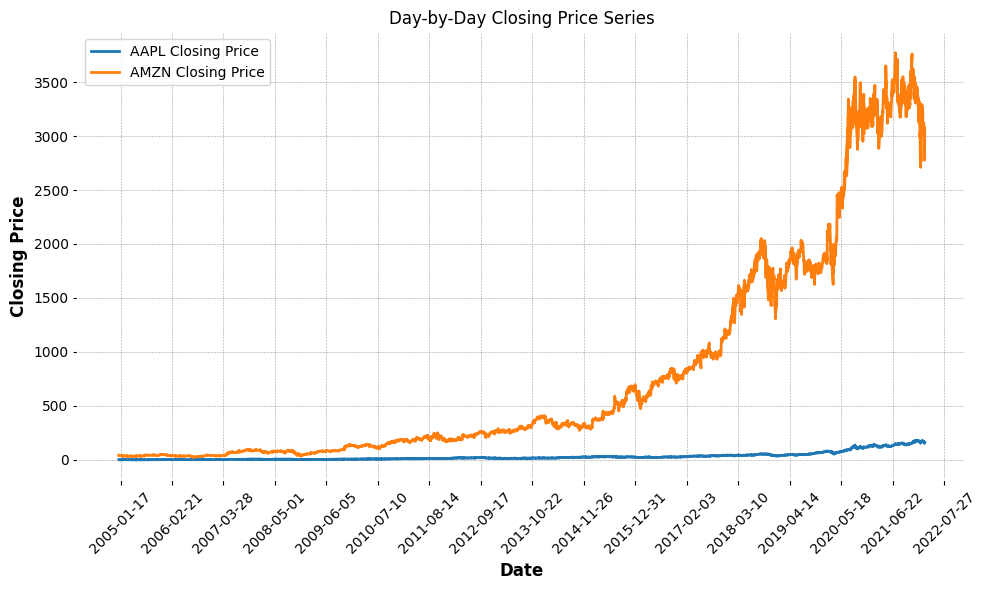

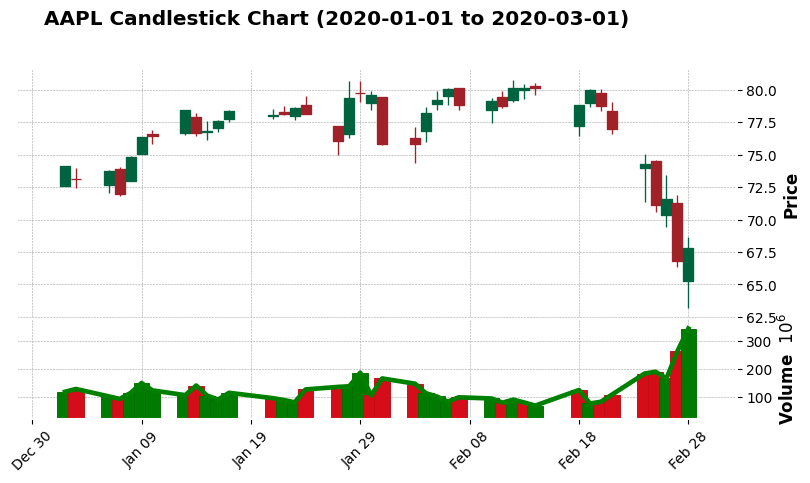

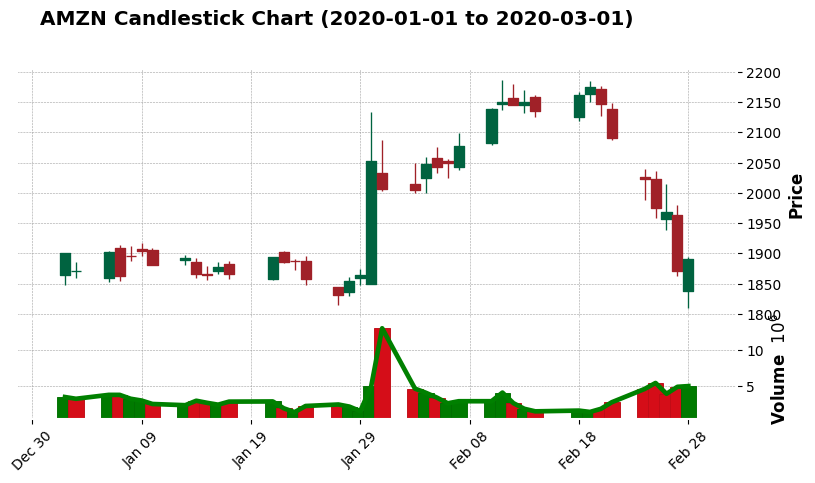

In [ ]:
stocks = ['AAPL','AMZN']
df_dict = create_df_dict(stocks)
plot_day_by_day_CP(df_dict, combine_plots=True)
plot_candlesticks(df_dict, start_date = '2020-01-01', end_date = '2020-03-01', freq = 'D')

### Q2. Normalising Data <a id="q2"></a>
- Try at least two ways to normalize the data as stock prices and volumes change over time and are
different across companies, and pick one by noting your justification.

> <span style="font-size: 20px;">Min-Max scaling</span> <a id="MMS"></a>

The `Min-Max scaling` scaling that I have used here scales the data for all the columns: 'Open', 'High', 'Low', 'Close', 'Volume' in the range [-1, 1]. The formula for `Min-Max scaling` is as follows (reference [[5]](#ref5)):

$$
X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
$$

In [ ]:
def min_max_scaler(df_dict):
    scaled_dict = {}
    for stock, df in df_dict.items():
        scaler = MinMaxScaler(feature_range=(-1, 1))               # Create a MinMaxScaler object
        scaled_data = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close','Volume']]) # Scale the OHLC columns
        scaled_df = df.copy()                                       # Create a copy of the original dataframe
        scaled_df[['Open', 'High', 'Low', 'Close','Volume']] = scaled_data   # Assign scaled values to OHLC columns
        scaled_dict[stock] = scaled_df
    return scaled_dict

In [ ]:
print("Original Dataframe for AMZN:")
print(df_dict['AMZN'].tail())
scaled_df_dict = min_max_scaler(df_dict)
print(f"Scaled Dataframe for AMZN:")
print(scaled_df_dict['AMZN'].tail())

Original Dataframe for AMZN:
                   DateTime    Open    High     Low   Close  Volume  \
2001742 2022-02-25 17:55:00  3074.7  3074.7  3074.7  3074.7     100   
2001743 2022-02-25 18:13:00  3074.0  3074.0  3074.0  3074.0     100   
2001744 2022-02-25 18:46:00  3075.0  3075.0  3075.0  3075.0     100   
2001745 2022-02-25 19:08:00  3077.5  3077.5  3077.5  3077.5     152   
2001746 2022-02-25 19:57:00  3075.0  3075.0  3075.0  3075.0     500   

               Date      Time  
2001742  2022-02-25  17:55:00  
2001743  2022-02-25  18:13:00  
2001744  2022-02-25  18:46:00  
2001745  2022-02-25  19:08:00  
2001746  2022-02-25  19:57:00  
Scaled Dataframe for AMZN:
                   DateTime      Open      High       Low     Close   Volume  \
2001742 2022-02-25 17:55:00  0.627733  0.627264  0.628057  0.627603 -1.00000   
2001743 2022-02-25 18:13:00  0.627360  0.626891  0.627683  0.627229 -1.00000   
2001744 2022-02-25 18:46:00  0.627894  0.627424  0.628217  0.627763 -1.00000   
20017

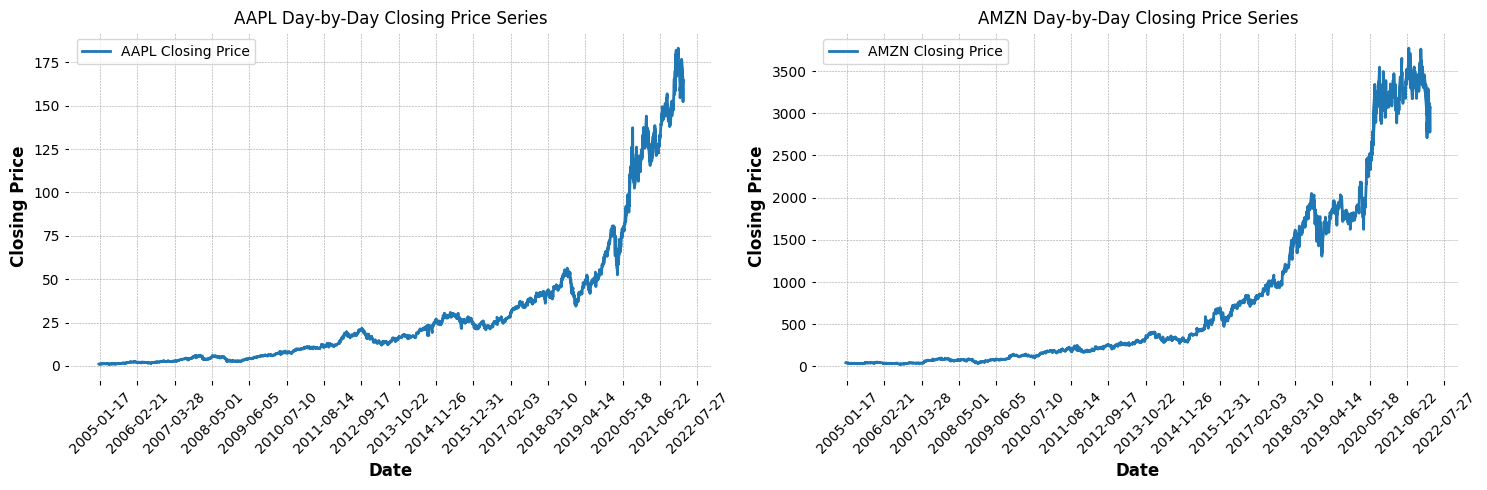

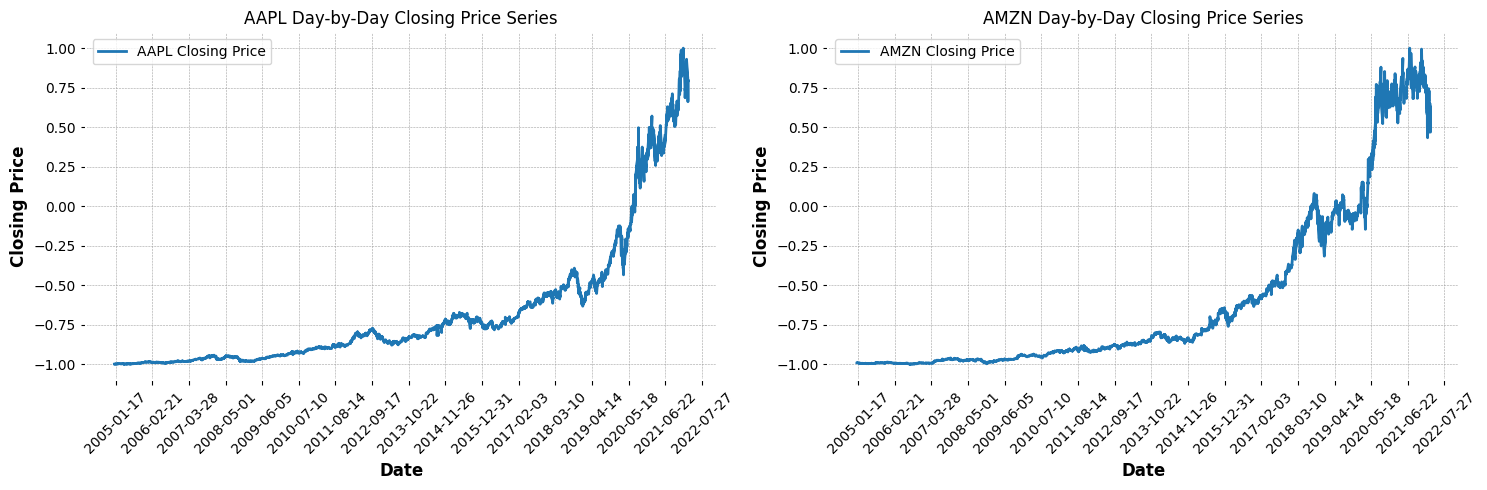

In [ ]:
plot_day_by_day_CP(df_dict, combine_plots=False)
plot_day_by_day_CP(scaled_df_dict, combine_plots=False)

We can notice that `Min-Max Scaling` ensures that all values have the same scale which is [-1,1] without distorting differences in the ranges of values. This is very helpful for LSTM models, as LSTMs are sensitive to the scale of input data. 

> <span style="font-size: 20px;">Z-Score Normalisation</span> <a id="MMS"></a>

`Z-Score Scaling`, centers and scales the data based on the mean ($ \mu $) and standard deviation ($ \sigma $). The transformation is defined as (reference [[5]](#ref5)):
$$
X_{\text{scaled}} = \frac{X - \mu}{\sigma}
$$

In [ ]:
def z_score_scaler(df_dict):
    scaled_dict = {}
    for stock, df in df_dict.items():
        scaler = StandardScaler()                                   # Z-Score normalization
        scaled_data = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close','Volume']])  # Scale the OHLC columns
        scaled_df = df.copy()                                       # Create a copy of the original dataframe
        scaled_df[['Open', 'High', 'Low', 'Close','Volume']] = scaled_data   # Assign scaled values to OHLC columns
        scaled_dict[stock] = scaled_df
    return scaled_dict

In [ ]:
scaled_df_dict_ZSN = z_score_scaler(df_dict)
print(f"Scaled Dataframe for AMZN:")
print(scaled_df_dict_ZSN['AMZN'].head())

Scaled Dataframe for AMZN:
             DateTime      Open      High       Low     Close    Volume  \
0 2005-01-03 08:00:00 -0.764494 -0.763958 -0.764462 -0.764308 -0.400828   
1 2005-01-03 08:01:00 -0.763934 -0.763801 -0.763951 -0.763964 -0.257553   
2 2005-01-03 08:02:00 -0.763767 -0.763752 -0.763734 -0.763718 -0.489544   
3 2005-01-03 08:03:00 -0.763718 -0.763752 -0.763734 -0.763718 -0.415691   
4 2005-01-03 08:04:00 -0.763718 -0.763526 -0.763734 -0.763522 -0.334914   

         Date      Time  
0  2005-01-03  08:00:00  
1  2005-01-03  08:01:00  
2  2005-01-03  08:02:00  
3  2005-01-03  08:03:00  
4  2005-01-03  08:04:00  


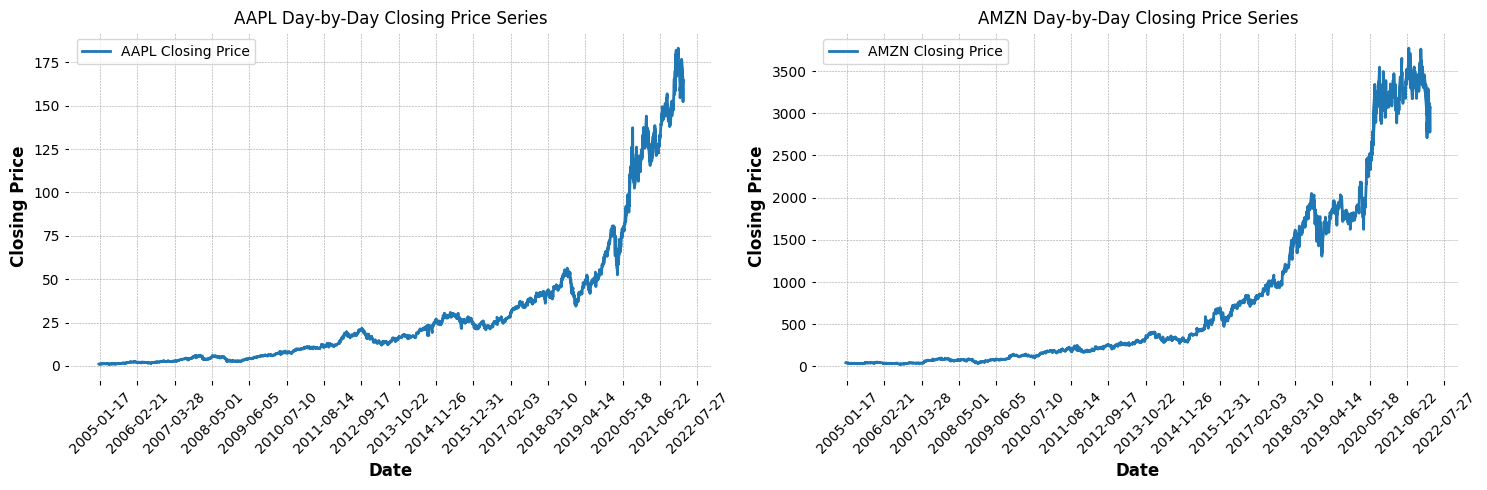

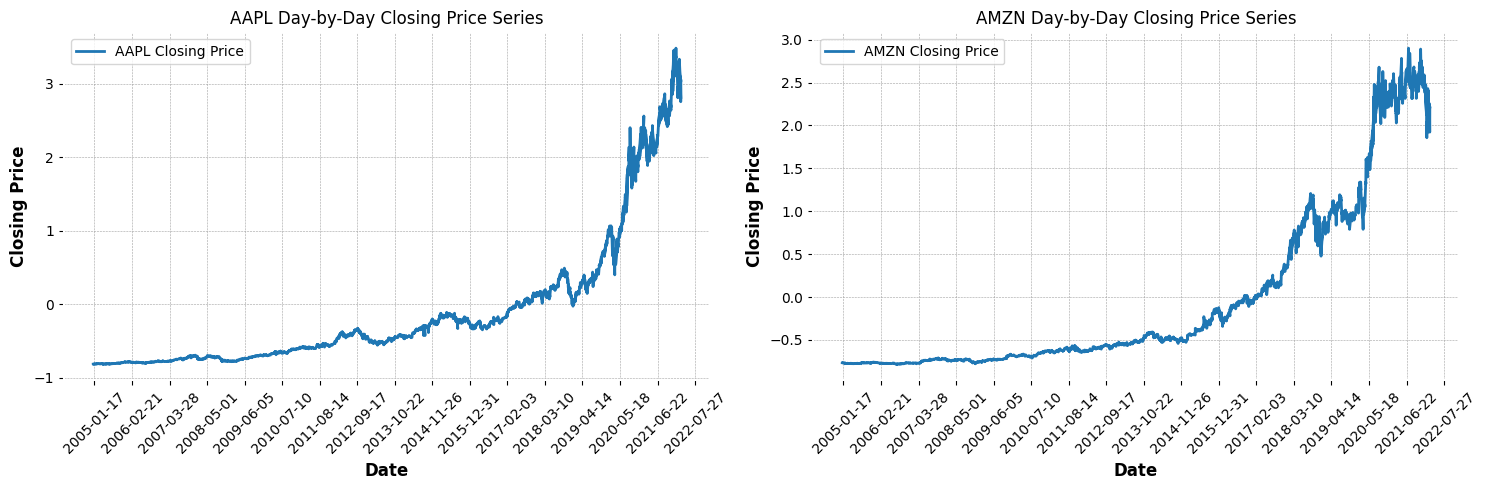

In [ ]:
plot_day_by_day_CP(df_dict, combine_plots=False)
plot_day_by_day_CP(scaled_df_dict_ZSN, combine_plots=False)

Since histograms plots are more suitable to visualise the scaling results after Z-Score Normalisation, I have plotted the histograms for the two companies, namely, `Apple` and `Amazon` for the columns: 'Open', 'High', 'Low', 'Close', 'Volume' before and after Z-Score Normalisation.

In [ ]:
def plot_histograms(dfs_dict):
    # Determine the number of plots required
    stocks = list(dfs_dict.keys())
    n_stocks = len(dfs_dict)
    nrows = (n_stocks + 1) // 2  # Calculate the number of rows needed for the given stocks
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 5 * nrows))
    axes = axes.ravel()
    
    for i, stock in enumerate(stocks):    
        ax = axes[i]
        sns.histplot(dfs_dict[stock]['Close'], bins=20, kde=True, ax=ax, label=f'{stock} Closing Price Distribution')
        ax.set_title(f'{stock} - Closing Price') 
        ax.set_xlabel('Closing Price')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True)

    if n_stocks % 2 != 0:
        fig.delaxes(axes[-1])

    plt.tight_layout()
    plt.show()

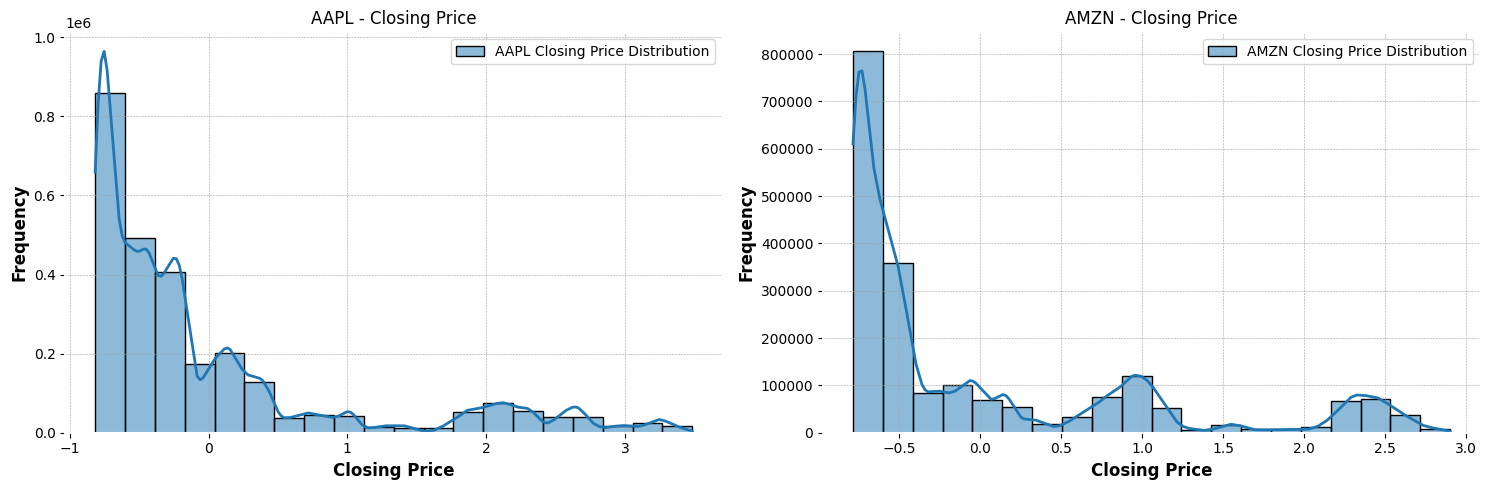

In [ ]:
plot_histograms(scaled_df_dict_ZSN)

We can see that the distribution of the closing price is not normal. This is because the closing price is not stationary. Hence I think that `Z-Score Scaling` is not a good choice for normalising the data.

> <span style="font-size: 20px;">Percentage Change Scaling</span> <a id="MMS"></a>

The `Percentage Change Scaling` computes the relative change between a value and its preceding value. For a series $ X $ with values $ X_1, X_2, \dots, X_n $, the percentage change for $ X_t $ is:

$$
\text{Percentage Change} = \frac{X_t - X_{t-1}}{X_{t-1}} \times 100
$$

This method is particularly useful for comparing the price movements of different stocks, as it puts the changes in stock prices on a relative scale, independent of the stock’s actual price level. (reference [[5]](#ref5)) Hence, for the time being I am not using this method for scaling the data.

In [ ]:
def percentage_change_scaler(dfs_dict):
    scaled_dfs_dict = {}
    
    for stock, df in dfs_dict.items():
        scaled_df = df.copy()
        
        # Compute percentage change for OHLC columns
        for column in ['Open', 'High', 'Low', 'Close','Volume']:
            scaled_df[column] = df[column].pct_change() * 100
        scaled_df = scaled_df.dropna()                  # Drop the first row with NaN values
        scaled_dfs_dict[stock] = scaled_df
        
    return scaled_dfs_dict

In [ ]:
scaled_df_dict_PCT = percentage_change_scaler(df_dict)
print(f"Scaled Dataframe for AMZN:")
print(scaled_df_dict_PCT['AMZN'].head())

Scaled Dataframe for AMZN:
             DateTime      Open      High       Low     Close      Volume  \
1 2005-01-03 08:01:00  1.279174  0.354453  1.166966  0.782123  133.677864   
2 2005-01-03 08:02:00  0.376690  0.110375  0.488021  0.554324  -92.628087   
3 2005-01-03 08:03:00  0.110375  0.000000  0.000000  0.000000  400.000000   
4 2005-01-03 08:04:00  0.000000  0.507166  0.000000  0.441014   87.500000   
5 2005-01-03 08:05:00  0.441014  0.021939  0.220751  0.087816  -36.000000   

         Date      Time  
1  2005-01-03  08:01:00  
2  2005-01-03  08:02:00  
3  2005-01-03  08:03:00  
4  2005-01-03  08:04:00  
5  2005-01-03  08:05:00  


One important point to note is that the percentage change for the first data point is always `NaN` as there is no preceding value to compare with. Hence, I have dropped the first row after computing the percentage change.

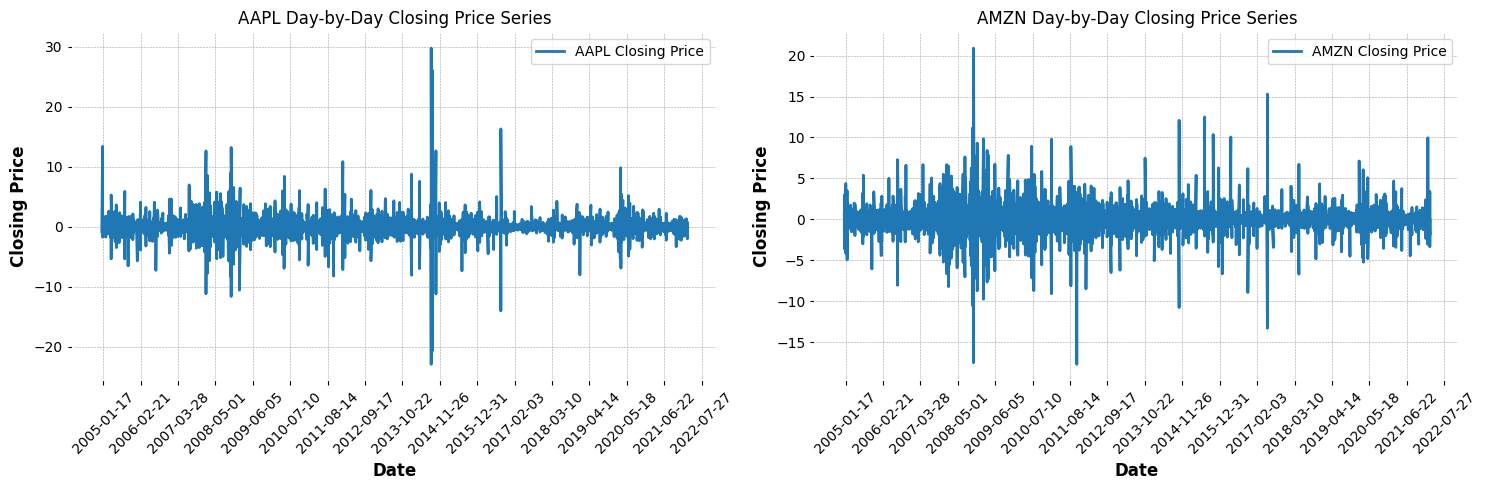

In [ ]:
plot_day_by_day_CP(scaled_df_dict_PCT, combine_plots=False)

> <span style="font-size: 20px;">Log Returns Scaling</span> <a id="MMS"></a>

The log return for a series $ X $ with values $ X_1, X_2, \dots, X_n $ is:

$$
\text{Log Return} = \log \left( \frac{X_t}{X_{t-1}} \right)
$$

This method can help stabilize the variances across time, especially if the stock prices exhibit exponential growth or decay. Log returns also have the property of time-additivity, which is valuable for time series forecasting. (reference [[5]](#ref5)) Hence, for the time being I am not using this method for scaling the data.

In [ ]:
def log_return_scaler(df_dict):
    scaled_dict = {}
    
    for stock, df in df_dict.items():
        scaled_df = df.copy()
        
        # Compute log return for OHLC columns
        for column in ['Open', 'High', 'Low', 'Close','Volume']:            # volume column also
            scaled_df[column] = np.log(df[column] / df[column].shift(1))
        scaled_df = scaled_df.dropna()                  # Drop the first row with NaN values
        scaled_dict[stock] = scaled_df
        
    return scaled_dict

In [ ]:
scaled_df_dict_LRS = log_return_scaler(df_dict)
print(f"Scaled Dataframe for AMZN:")
print(scaled_df_dict_LRS['AMZN'].head())

Scaled Dataframe for AMZN:
             DateTime      Open      High       Low     Close    Volume  \
1 2005-01-03 08:01:00  0.012711  0.003538  0.011602  0.007791  0.848773   
2 2005-01-03 08:02:00  0.003760  0.001103  0.004868  0.005528 -2.607493   
3 2005-01-03 08:03:00  0.001103  0.000000  0.000000  0.000000  1.609438   
4 2005-01-03 08:04:00  0.000000  0.005059  0.000000  0.004400  0.628609   
5 2005-01-03 08:05:00  0.004400  0.000219  0.002205  0.000878 -0.446287   

         Date      Time  
1  2005-01-03  08:01:00  
2  2005-01-03  08:02:00  
3  2005-01-03  08:03:00  
4  2005-01-03  08:04:00  
5  2005-01-03  08:05:00  


Similar to Percentage Change Scaling, the first row of Dataframe will result in a `NaN` value due to the absence of a previous data point for calculation, so I have dropped it.

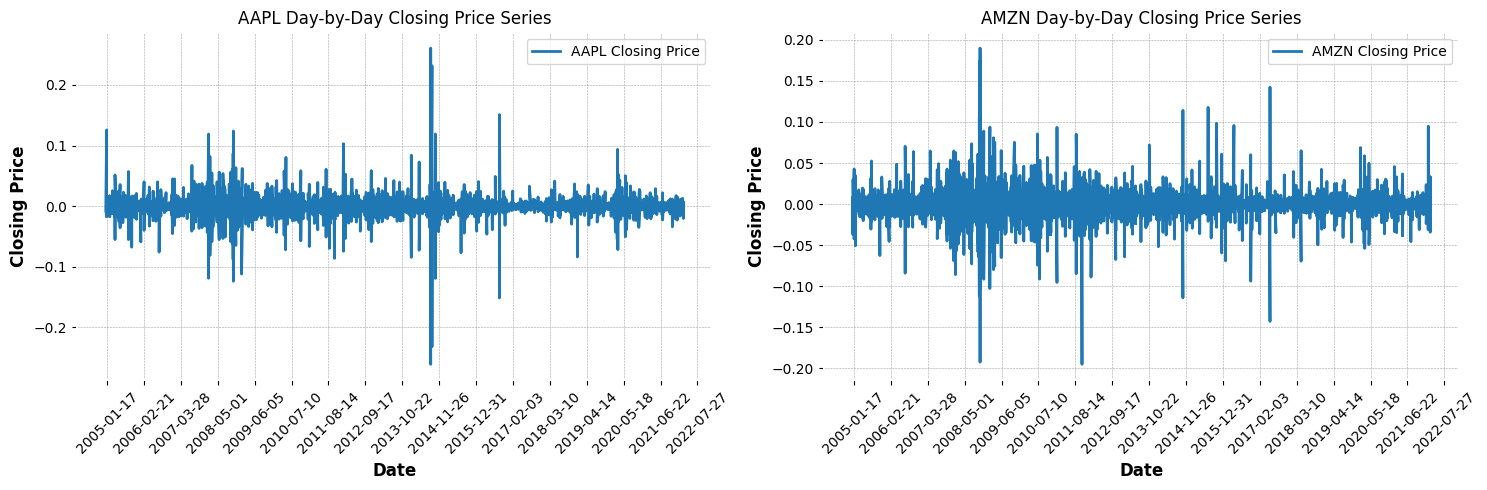

In [ ]:
plot_day_by_day_CP(scaled_df_dict_LRS, combine_plots=False)

Given the explanations and observations above, it seems that `Min Max Scaling` is best suited for the LSTM model. This is primarily because LSTMs benefit from consistent and scaled input data, ensuring that all features contribute equally to the model's learning process. `Min Max Scaling` also avoids potential issues arising from non-normal distributions or skewness in the data. Hence I have used `Min Max Scaling` for scaling the data from now onwards.

### Q3. Scenarios <a id="q3"></a>
- Make some Scenario decisions:
#### Q3a. Trading Strategies <a id="q3a"></a>
- high-frequency trading or intra-day swing, or inter-day trade, or long-term (multi-day or
multi-week or multi-month).
> <span style="font-size: 20px;">Intra-day Swing Trading</span> <a id="MMS"></a>

#### Q3b. Buy-Ask Spread<a id="q3b"></a>
- Assume a buy-ask spread (inversely related to volume and directly related to price) and
trade commission based on a quick market research. Your trade will lose the buy-ask
spread and commissions every time you trade.

#### Q3c. Trading Frequency <a id="q3c"></a>
- Decide if you will trade only one stock, or have a model to trade a basket from a particular
industry, or any stock.

### Working with Single Stock <a id="single-stock"></a>
For simplicty, let us now work with only one stock, namely, `Apple`.

In [ ]:
stocks = ['AAPL']
df_dict = create_df_dict(stocks)

In [ ]:
print(f"Original Dataframe for '{stocks[0]}':")
df_dict[stocks[0]]

Original Dataframe for 'AAPL':


,DateTime,Open,High,Low,Close,Volume
0,2005-01-03 08:00:00,0.9939,0.9944,0.9939,0.9944,39200
1,2005-01-03 08:02:00,0.9863,0.9863,0.9863,0.9863,304360
2,2005-01-03 08:03:00,0.9955,0.9956,0.9955,0.9956,16800
3,2005-01-03 08:04:00,0.9962,0.9985,0.9962,0.9985,161504
4,2005-01-03 08:07:00,0.9971,0.9971,0.9970,0.9970,50400
...,...,...,...,...,...,...
2743498,2022-02-25 19:54:00,164.3100,164.3100,164.3100,164.3100,350
2743499,2022-02-25 19:55:00,164.3200,164.3200,164.3200,164.3200,100
2743500,2022-02-25 19:57:00,164.3800,164.3800,164.3800,164.3800,422
2743501,2022-02-25 19:58:00,164.3400,164.3400,164.3300,164.3300,557


In [ ]:
def get_latest_df_dict(df_dict, years_to_keep=years_to_keep):
    """
    Filters each dataframe to keep only the latest data based on a given number of years.
    
    Parameters:
    - df_dict (dict): Dictionary containing stock dataframes.
    - years_to_keep (int, optional): Number of years of data to retain. Defaults to 10.
    
    Returns:
    - latest_df_dict (dict): Dictionary containing the latest data for each stock.
    """
    latest_df_dict = {}
    # df_dict_temp = separate_datetime_dfs_dict(df_dict)        # Ensure that the DateTime column is converted to Date and Time columns
    for stock, df in df_dict.items():
        df['DateTime'] = pd.to_datetime(df['DateTime'])       # Convert to datetime type
        latest_df = df[df['DateTime'] >= df['DateTime'].max() - pd.DateOffset(years=years_to_keep)]
        latest_df_dict[stock] = latest_df
    
    return latest_df_dict

In [ ]:
latest_df_dict = get_latest_df_dict(df_dict) 
latest_df_dict[stocks[0]]

,DateTime,Open,High,Low,Close,Volume
1035506,2012-02-27 04:14:00,15.9105,15.9105,15.9105,15.9105,11200
1035507,2012-02-27 04:16:00,15.9105,15.9105,15.9105,15.9105,16800
1035508,2012-02-27 04:18:00,15.9105,15.9105,15.9105,15.9105,2800
1035509,2012-02-27 04:21:00,15.9105,15.9105,15.9105,15.9105,2800
1035510,2012-02-27 05:16:00,15.9105,15.9105,15.9105,15.9105,5600
...,...,...,...,...,...,...
2743498,2022-02-25 19:54:00,164.3100,164.3100,164.3100,164.3100,350
2743499,2022-02-25 19:55:00,164.3200,164.3200,164.3200,164.3200,100
2743500,2022-02-25 19:57:00,164.3800,164.3800,164.3800,164.3800,422
2743501,2022-02-25 19:58:00,164.3400,164.3400,164.3300,164.3300,557


In [ ]:
def scale_df_dict(df_dict):
    """
    Applies Min-Max Scaling and Scales the data in each dataframe between -1 and 1.
    
    Parameters:
    - df_dict (dict): Dictionary containing stock dataframes.
    
    Returns:
    - scaled_df_dict, scalers_dict (tuple): A tuple containing the scaled dataframes dictionary and a dictionary of scalers used for each column.
    """
    scaled_df_dict = {}
    scalers_dict = {}
    for stock, df in df_dict.items():
        scaled_df = pd.DataFrame()
        scaled_df['DateTime'] = df['DateTime']
        cols = list(df)[1:]
        for col in cols:
            scaler = MinMaxScaler(feature_range=(-1, 1))
            scaled_df[col] = scaler.fit_transform(df[[col]].astype(float))
            scalers_dict[(stock, col)] = scaler
        scaled_df_dict[stock] = scaled_df
        
    return scaled_df_dict, scalers_dict

In [ ]:
scaled_df_dict, scalers_dict = scale_df_dict(latest_df_dict)

In [ ]:
print(f"Dataframe for '{stocks[0]}' (Scaled):")
scaled_df_dict[stocks[0]]

Dataframe for 'AAPL' (Scaled):


,DateTime,Open,High,Low,Close,Volume
1035506,2012-02-27 04:14:00,-0.954082,-0.954220,-0.953747,-0.954069,-0.999863
1035507,2012-02-27 04:16:00,-0.954082,-0.954220,-0.953747,-0.954069,-0.999794
1035508,2012-02-27 04:18:00,-0.954082,-0.954220,-0.953747,-0.954069,-0.999967
1035509,2012-02-27 04:21:00,-0.954082,-0.954220,-0.953747,-0.954069,-0.999967
1035510,2012-02-27 05:16:00,-0.954082,-0.954220,-0.953747,-0.954069,-0.999932
...,...,...,...,...,...,...
2743498,2022-02-25 19:54:00,0.779901,0.779886,0.780147,0.780110,-0.999997
2743499,2022-02-25 19:55:00,0.780018,0.780003,0.780263,0.780227,-1.000000
2743500,2022-02-25 19:57:00,0.780719,0.780704,0.780964,0.780928,-0.999996
2743501,2022-02-25 19:58:00,0.780252,0.780236,0.780380,0.780344,-0.999994


In [ ]:
def train_test_df_split(df_dict):
    """
    Splits each dataframe into training, validation, and test sets.
    
    Parameters:
    - df_dict (dict): Dictionary containing stock dataframes.
    
    Returns:
    - train_df_dict, valid_df_dict, test_df_dict (tuple): A tuple containing dictionaries for training, validation, and test data for each stock.
    """    
    train_df_dict = {}
    valid_df_dict = {}
    test_df_dict = {}
    for stock, df in df_dict.items():
        df['DateTime'] = pd.to_datetime(df['DateTime'])  # Ensure the DateTime column is of datetime type
        
        # Find the date that is two years before the last date in the dataframe
        offset_date = df['DateTime'].iloc[-1] - pd.DateOffset(years=2)
        
        # Separate out the last two years for the test set
        mask = df['DateTime'] >= offset_date
        test_df = df[mask]
        
        # From the remaining data, split 10% for the validation set
        remaining_df = df[~mask]
        valid_length = int(0.1 * len(remaining_df))
        valid_df = remaining_df[-valid_length:]
        
        # The rest of the data is for the training set
        train_df = remaining_df[:-valid_length]
        
        train_df_dict[stock] = train_df
        valid_df_dict[stock] = valid_df
        test_df_dict[stock] = test_df
        
    return train_df_dict, valid_df_dict, test_df_dict

In [ ]:
train_df_dict, valid_df_dict, test_df_dict = train_test_df_split(scaled_df_dict)
print(f"Length of Train Dataframe for {stocks[0]},'Close' Column: {len(train_df_dict[stocks[0]])} ({len(train_df_dict[stocks[0]]) / len(scaled_df_dict[stocks[0]]) * 100:.2f}%)")
print(f"Length of Validation Dataframe for {stocks[0]},'Close' Column: {len(valid_df_dict[stocks[0]])} ({len(valid_df_dict[stocks[0]]) / len(scaled_df_dict[stocks[0]]) * 100:.2f}%)")
print(f"Length of Test Dataframe for {stocks[0]},'Close' Column: {len(test_df_dict[stocks[0]])} ({len(test_df_dict[stocks[0]]) / len(scaled_df_dict[stocks[0]]) * 100:.2f}%)")

Length of Train Dataframe for AAPL,'Close' Column: 1164100 (68.16%)
Length of Validation Dataframe for AAPL,'Close' Column: 129344 (7.57%)
Length of Test Dataframe for AAPL,'Close' Column: 414553 (24.27%)


In [ ]:
print(f"'{stocks[0]}' Dataframe (Scaled):")
scaled_df_dict[stocks[0]]

'AAPL' Dataframe (Scaled):


,DateTime,Open,High,Low,Close,Volume
1035506,2012-02-27 04:14:00,-0.954082,-0.954220,-0.953747,-0.954069,-0.999863
1035507,2012-02-27 04:16:00,-0.954082,-0.954220,-0.953747,-0.954069,-0.999794
1035508,2012-02-27 04:18:00,-0.954082,-0.954220,-0.953747,-0.954069,-0.999967
1035509,2012-02-27 04:21:00,-0.954082,-0.954220,-0.953747,-0.954069,-0.999967
1035510,2012-02-27 05:16:00,-0.954082,-0.954220,-0.953747,-0.954069,-0.999932
...,...,...,...,...,...,...
2743498,2022-02-25 19:54:00,0.779901,0.779886,0.780147,0.780110,-0.999997
2743499,2022-02-25 19:55:00,0.780018,0.780003,0.780263,0.780227,-1.000000
2743500,2022-02-25 19:57:00,0.780719,0.780704,0.780964,0.780928,-0.999996
2743501,2022-02-25 19:58:00,0.780252,0.780236,0.780380,0.780344,-0.999994


In [ ]:
print(f"'{stocks[0]}' Training Dataframe (Scaled):")
train_df_dict[stocks[0]]

'AAPL' Training Dataframe (Scaled):


,DateTime,Open,High,Low,Close,Volume
1035506,2012-02-27 04:14:00,-0.954082,-0.954220,-0.953747,-0.954069,-0.999863
1035507,2012-02-27 04:16:00,-0.954082,-0.954220,-0.953747,-0.954069,-0.999794
1035508,2012-02-27 04:18:00,-0.954082,-0.954220,-0.953747,-0.954069,-0.999967
1035509,2012-02-27 04:21:00,-0.954082,-0.954220,-0.953747,-0.954069,-0.999967
1035510,2012-02-27 05:16:00,-0.954082,-0.954220,-0.953747,-0.954069,-0.999932
...,...,...,...,...,...,...
2199601,2019-05-21 12:30:00,-0.604668,-0.604752,-0.604836,-0.605072,-0.998524
2199602,2019-05-21 12:31:00,-0.605135,-0.605152,-0.604893,-0.605069,-0.997917
2199603,2019-05-21 12:32:00,-0.605068,-0.605095,-0.604808,-0.604928,-0.998786
2199604,2019-05-21 12:33:00,-0.604981,-0.605081,-0.605036,-0.604958,-0.998615


In [ ]:
print(f"'{stocks[0]}' Validation Dataframe (Scaled):")
valid_df_dict[stocks[0]]

'AAPL' Validation Dataframe (Scaled):


,DateTime,Open,High,Low,Close,Volume
2199606,2019-05-21 12:35:00,-0.605099,-0.605095,-0.605293,-0.605529,-0.997062
2199607,2019-05-21 12:36:00,-0.605582,-0.605523,-0.605321,-0.605443,-0.998676
2199608,2019-05-21 12:37:00,-0.605495,-0.605367,-0.605224,-0.605268,-0.998375
2199609,2019-05-21 12:38:00,-0.605309,-0.605381,-0.605522,-0.605585,-0.997676
2199610,2019-05-21 12:39:00,-0.605582,-0.605521,-0.605435,-0.605557,-0.998872
...,...,...,...,...,...,...
2328945,2020-02-25 19:53:00,-0.307511,-0.307603,-0.307930,-0.308146,-0.999968
2328946,2020-02-25 19:55:00,-0.307799,-0.307892,-0.307699,-0.307713,-0.999969
2328947,2020-02-25 19:56:00,-0.307943,-0.308006,-0.307844,-0.308059,-0.999929
2328948,2020-02-25 19:57:00,-0.308087,-0.308179,-0.308707,-0.308923,-0.999870


In [ ]:
print(f"'{stocks[0]}' Test Dataframe (Scaled):")
test_df_dict[stocks[0]]

'AAPL' Test Dataframe (Scaled):


,DateTime,Open,High,Low,Close,Volume
2328950,2020-02-25 19:59:00,-0.308663,-0.308755,-0.308938,-0.309154,-0.999891
2328951,2020-02-26 04:00:00,-0.317884,-0.317978,-0.318447,-0.318664,-0.999967
2328952,2020-02-26 04:01:00,-0.318605,-0.318699,-0.319628,-0.319816,-0.999784
2328953,2020-02-26 04:02:00,-0.321054,-0.321148,-0.320752,-0.320970,-0.999996
2328954,2020-02-26 04:03:00,-0.321025,-0.321119,-0.320723,-0.320940,-0.999985
...,...,...,...,...,...,...
2743498,2022-02-25 19:54:00,0.779901,0.779886,0.780147,0.780110,-0.999997
2743499,2022-02-25 19:55:00,0.780018,0.780003,0.780263,0.780227,-1.000000
2743500,2022-02-25 19:57:00,0.780719,0.780704,0.780964,0.780928,-0.999996
2743501,2022-02-25 19:58:00,0.780252,0.780236,0.780380,0.780344,-0.999994


In [ ]:
def df_to_tensors(df, seq_length, pred_horizon, predict = 'Close'): 
    """
    Converts a dataframe into input and target tensors for the LSTM model.
    
    Parameters:
    - df (pd.DataFrame): Input dataframe.
    - seq_length (int): Sequence Length for LSTM.
    - pred_horizon (int): Prediction horizon.
    - predict (str, optional): Column name to predict. Defaults to 'Close'.
    
    Returns:
    - X, Y (tuple): Input and target tensors.
    """
    df = df.drop('DateTime', axis=1)
    df_as_np = np.array(df)
    predict_col_idx = list(df.columns).index(predict)
    X_list, Y_list = [], []
    for i in range(seq_length, len(df_as_np) - pred_horizon +1):
        X_list.append(df_as_np[i - seq_length:i, :df_as_np.shape[1]])
        Y_list.append(df_as_np[i + pred_horizon - 1:i + pred_horizon, predict_col_idx])       
    X_np, Y_np = np.array(X_list), np.array(Y_list)
    X, Y = torch.tensor(X_np, dtype=torch.float32), torch.tensor(Y_np, dtype=torch.float32)   
    return X, Y

In [ ]:
X, Y = df_to_tensors(scaled_df_dict[stocks[0]], seq_length=seq_length, pred_horizon=pred_horizon, predict = predict)
print(f"X shape: {X.shape}, Y shape: {Y.shape}")

X shape: torch.Size([1707990, 7, 5]), Y shape: torch.Size([1707990, 1])


In [ ]:
print(X[0])

tensor([[-0.9541, -0.9542, -0.9537, -0.9541, -0.9999],
        [-0.9541, -0.9542, -0.9537, -0.9541, -0.9998],
        [-0.9541, -0.9542, -0.9537, -0.9541, -1.0000],
        [-0.9541, -0.9542, -0.9537, -0.9541, -1.0000],
        [-0.9541, -0.9542, -0.9537, -0.9541, -0.9999],
        [-0.9542, -0.9544, -0.9539, -0.9542, -1.0000],
        [-0.9542, -0.9544, -0.9539, -0.9542, -0.9999]])


In [ ]:
print(X[1])

tensor([[-0.9541, -0.9542, -0.9537, -0.9541, -0.9998],
        [-0.9541, -0.9542, -0.9537, -0.9541, -1.0000],
        [-0.9541, -0.9542, -0.9537, -0.9541, -1.0000],
        [-0.9541, -0.9542, -0.9537, -0.9541, -0.9999],
        [-0.9542, -0.9544, -0.9539, -0.9542, -1.0000],
        [-0.9542, -0.9544, -0.9539, -0.9542, -0.9999],
        [-0.9543, -0.9545, -0.9540, -0.9543, -1.0000]])


In [ ]:
print(Y)                # Y is the next day's closing or opening price depending on predict = 'Close' or 'Open'

tensor([[-0.9543],
        [-0.9542],
        [-0.9542],
        ...,
        [ 0.7809],
        [ 0.7803],
        [ 0.7805]])


In [ ]:
X_train, Y_train = df_to_tensors(train_df_dict[stocks[0]], seq_length=seq_length, pred_horizon=pred_horizon, predict = predict)
X_valid, Y_valid = df_to_tensors(valid_df_dict[stocks[0]], seq_length=seq_length, pred_horizon=pred_horizon, predict = predict)
X_test, Y_test = df_to_tensors(test_df_dict[stocks[0]], seq_length=seq_length, pred_horizon=pred_horizon, predict = predict)

In [ ]:
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_valid shape: {X_valid.shape}, Y_valid shape: {Y_valid.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train shape: torch.Size([1164093, 7, 5]), Y_train shape: torch.Size([1164093, 1])
X_valid shape: torch.Size([129337, 7, 5]), Y_valid shape: torch.Size([129337, 1])
X_test shape: torch.Size([414546, 7, 5]), Y_test shape: torch.Size([414546, 1])


### Q4. LSTM Model <a id="q4"></a>
- Write a pytorch module for defining an LSTM model. Keep it flexible so that the input dimension,
number of units, number of layers can easily be changed.

In [ ]:
# Defining a flexible LSTM model using PyTorch
class LSTM(nn.Module):
    """
    LSTM model for time series forecasting.
    
    Attributes:
    - input_dim (int): Number of input features.
    - hidden_dim (int): Number of hidden units.
    - num_layers (int): Number of LSTM layers.
    - output_dim (int): Number of output dimensions
    """
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        
        # Hidden dimensions and number of layers
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Define the output layer
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        
        # Pass through the LSTM layers
        out, (hn,cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Only take the output from the final time step
        out = self.linear(out[:, -1, :])
        return out

In [ ]:
model = LSTM(input_dim=X_train.shape[2], hidden_dim=hidden_dim, num_layers=num_layers, output_dim=Y_train.shape[1]).to(device)
print(model)

LSTM(
  (lstm): LSTM(5, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


### Q5. DataLoader <a id="q5"></a>
- Write a flexible dataloader for training the LSTM model, especially if you are high frequency data.
The inputs should be open, close, high, low, volume of one or more stocks (e.g. other stocks that can
help predict the chosen stock price).

In [ ]:
class StockDataset(Dataset):
    """
    Dataset class for stock data.
    """
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

Input to Dataloader is now only 'Close' column

In [ ]:
train_dataset = StockDataset(X_train, Y_train)
valid_dataset = StockDataset(X_valid, Y_valid)
test_dataset = StockDataset(X_test, Y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

In [ ]:
print(f"Number of training sequences: {len(train_loader.dataset)}")
print(f"Number of validation sequences: {len(valid_loader.dataset)}")
print(f"Number of test sequences: {len(test_loader.dataset)}")  
for X, Y in train_loader:
    print(f"X shape: {X.shape}, Y shape: {Y.shape}")
    break

Number of training sequences: 1164093
Number of validation sequences: 129337
Number of test sequences: 414546
X shape: torch.Size([64, 7, 5]), Y shape: torch.Size([64, 1])


> **Sequence shape:** $[BatchSize \times Sequence Length \times No. of columns]$
> 
> **Target shape:** $[BatchSize]$

### Q6. Training Loop <a id="q5"></a>
- Train or pre-train the model by trying to predict the future price (or change in price, if normalized)
and keep the future horizon flexible (e.g., easy to change between one minute or 10 minutes into the
future). You can try to predict the opening or closing time. Leave the last two years out for testing.

In [ ]:
def train_model(model, train_loader, valid_loader, num_epochs, learning_rate, regularize):
    """
    Training Loop function
    
    Parameters:
    - model (LSTM): LSTM model to train.
    - train_loader (DataLoader): Training data loader.
    - valid_loader (DataLoader): Validation data loader.
    - num_epochs (int): Number of epochs for training.
    - learning_rate (float): Learning rate for optimization.
    - regularize (bool): Whether to apply regularization.
    
    Returns:
    - tuple: Trained model, training losses per epoch, and validation losses per epoch.
    """
    # Transfer the model to the device
    model = model.to(device)
    
    # Define the loss function and the optimizer
    criterion = nn.MSELoss()  # Using Mean Squared Error Loss for regression
    if regularize:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
     
    # Lists to store the average loss per epoch for training and validation
    train_losses = []
    valid_losses = []
    
    for epoch in range(1, num_epochs+1):
        model.train()  # Set the model to training mode
        running_train_loss = 0.0
        # Using tqdm for the training loop to display a progress bar
        pbar = tqdm(train_loader, total=len(train_loader), leave=False)
       
        for _, batch in enumerate(pbar):
            # Transfer sequences and labels to device
            X_batch, Y_batch = batch[0].to(device), batch[1].to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            running_train_loss += loss.item()
            
            # Backward pass and optimization
            loss.backward()
            
            optimizer.step()
            
            # Update progress bar
            pbar.set_postfix(train_loss=loss.item())
        
        # Average training loss
        avg_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        # Validation loss
        model.eval()  # Set the model to evaluation mode
        running_valid_loss = 0.0
        for _, batch in enumerate(valid_loader):
            X_batch, Y_batch = batch[0].to(device), batch[1].to(device)
            
            with torch.no_grad():
                outputs = model(X_batch)
                loss = criterion(outputs, Y_batch)
                running_valid_loss += loss.item()
                
        # Average validation loss
        avg_valid_loss = running_valid_loss / len(valid_loader.dataset)
        valid_losses.append(avg_valid_loss)
        
        # Print epoch details
        print(f'''{"#"*100}
Epoch: [{epoch}/{num_epochs}] | Epoch Train Loss: {avg_train_loss} | Epoch Valid Loss: {avg_valid_loss}
{"#"*100}''')
    
    return model, train_losses, valid_losses

In [ ]:
trained_model, train_losses, valid_losses = train_model(model, train_loader, valid_loader, num_epochs=5, learning_rate=learning_rate, regularize=regularize)

####################################################################################################
Epoch: [1/5] | Epoch Train Loss: 1.3512353761664827e-06 | Epoch Valid Loss: 6.621903857350884e-07
####################################################################################################


####################################################################################################
Epoch: [2/5] | Epoch Train Loss: 5.776886320069845e-08 | Epoch Valid Loss: 4.3534666726558943e-07
####################################################################################################


####################################################################################################
Epoch: [3/5] | Epoch Train Loss: 3.784227466083884e-08 | Epoch Valid Loss: 3.716174556817686e-06
####################################################################################################


####################################################################################################
Epoch: [4/5] | Epoch Train Loss: 2.9723713652871638e-08 | Epoch Valid Loss: 1.4693299205786913e-05
####################################################################################################


####################################################################################################
Epoch: [5/5] | Epoch Train Loss: 2.519192359413815e-08 | Epoch Valid Loss: 1.6838449268570677e-05
####################################################################################################


In [ ]:
def plot_losses(train_losses, valid_losses):
    """
    Plots training and validation losses per epoch.
    
    Parameters:
    - train_losses (list): Training losses per epoch.
    - valid_losses (list): Validation losses per epoch.
    """
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(8, 4))
    
    # Plotting train losses
    plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='blue')
    
    # Plotting valid losses
    plt.plot(epochs, valid_losses, label='Validation Loss', marker='o', color='red')
    
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()

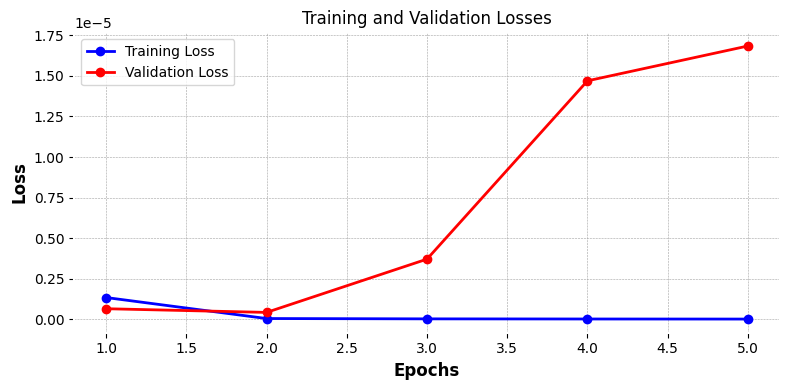

In [ ]:
plot_losses(train_losses, valid_losses)

#### Predictions on Validataion Data <a id="predictions-on-validation-data"></a>
Let us first check out predictions on the validation set.

In [ ]:
with torch.no_grad():
    Y_valid_pred = trained_model(X_valid.to(device)).to('cpu').numpy()

Here Column = 'Close' or 'Open' whichever is predicted

In [ ]:
def descale_data(scaled_data, stock, column = predict, scalers_dict = scalers_dict):
    """
    Converts scaled data back to its original scale.
    
    Parameters:
    - scaled_data (array-like): Data that was scaled.
    - stock (str): Name of the stock.
    - column (str, optional): Column name of the data. Defaults to 'Close'.
    - scalers_dict (dict, optional): Dictionary of scalers used for each column. Defaults to scalers_dict.
    
    Returns:
    - array: Data in its original scale.
    """
    # Ensure scaled_data is a numpy array
    if isinstance(scaled_data, torch.Tensor):
        scaled_data_np = scaled_data.numpy()
    elif isinstance(scaled_data, pd.Series):
        scaled_data_np = scaled_data.values
    elif isinstance(scaled_data, list):
        scaled_data_np = np.array(scaled_data)
    else:
        scaled_data_np = scaled_data
    
    # Retrieve the appropriate scaler
    scaler = scalers_dict[(stock, column)]
    
    # Descale the data
    descaled_data = scaler.inverse_transform(scaled_data_np.reshape(-1, 1))
    
    return descaled_data

In [ ]:
Y_valid_descaled = descale_data(scaled_data=Y_valid, stock=stocks[0])       # column = 'Close' or 'Open' whichever is predicted
Y_valid_pred_descaled = descale_data(scaled_data=Y_valid_pred, stock=stocks[0])

In [ ]:
print(Y_valid_descaled.flatten())
print(Y_valid_pred_descaled.flatten())

[45.753304 45.740406 45.759502 ... 71.1917   71.1178   71.1474  ]
[45.73418  45.74559  45.744476 ... 73.9702   73.95011  73.89566 ]


In [ ]:
def create_pred_df_dict(df_dict, actual, predictions, seq_length = seq_length, predict = predict, pred_horizon = pred_horizon):
    """
    Creates a dataframe for actual vs predicted values.
    
    Parameters:
    - df_dict (dict): Dictionary containing original dataframes.
    - actual (array): Actual values.
    - predictions (array): Predicted values.
    - seq_length (int, optional): Length of the sequence for LSTM. Defaults to 7.
    - predict (str, optional): Column name to predict. Defaults to 'Close'.
    - pred_horizon (int, optional): Prediction horizon. Defaults to 1.
    
    Returns:
    - dict: Dictionary containing dataframes with actual vs predicted values for each stock.
    """    
    pred_df_dict = {}
    
    for stock, df in df_dict.items():
        pred_df = pd.DataFrame()
        start_index = seq_length
        end_index = -pred_horizon + 1 if pred_horizon > 1 else None
        pred_df['DateTime'] = df['DateTime'].iloc[start_index:end_index]
        pred_df[f'{predict} (Actual)'] = actual[:, 0]
        pred_df[f'{predict} (Predicted)'] = predictions[:, 0]
        pred_df_dict[stock] = pred_df
        
    return pred_df_dict

In [ ]:
pred_df_dict = create_pred_df_dict(valid_df_dict, Y_valid_descaled, Y_valid_pred_descaled)

In [ ]:
print(f"'{stocks[0]}': {predict} (Actual) vs. {predict} (Predicted) on Validation Set:")
pred_df_dict[stocks[0]]

'AAPL': Close (Actual) vs. Close (Predicted) on Validation Set:


,DateTime,Close (Actual),Close (Predicted)
2199613,2019-05-21 12:42:00,45.753304,45.734180
2199614,2019-05-21 12:43:00,45.740406,45.745590
2199615,2019-05-21 12:44:00,45.759502,45.744476
2199616,2019-05-21 12:45:00,45.748505,45.746372
2199617,2019-05-21 12:46:00,45.728901,45.755344
...,...,...,...
2328945,2020-02-25 19:53:00,71.184303,73.971649
2328946,2020-02-25 19:55:00,71.221306,73.971718
2328947,2020-02-25 19:56:00,71.191704,73.970200
2328948,2020-02-25 19:57:00,71.117798,73.950111


In [ ]:
def plot_actual_vs_predicted(df_dict, predict= predict):
    """
    Plots actual vs predicted values for each stock.
    
    Parameters:
    - df_dict (dict): Dictionary containing dataframes with actual vs predicted values.
    - predict (str, optional): Column name to predict. Defaults to 'Close'.
    """
    df_dict = separate_datetime_dfs_dict(df_dict)
    stocks = list(df_dict.keys())
    for stock in stocks:
        fig, ax = plt.subplots(figsize=(10, 5))
        
        ax.plot(df_dict[stock]['DateTime'], df_dict[stock][f'{predict} (Actual)'], label=f'{predict} Price (Actual)', color='blue')
        ax.plot(df_dict[stock]['DateTime'], df_dict[stock][f'{predict} (Predicted)'], label=f'{predict} Price (Predicted)', color='orange')
        
        ax.set_title(f"{stock} - Actual vs. Predicted '{predict}' Prices")
        ax.set_xlabel('Date')
        ax.set_ylabel('Closing Price')
        ax.legend()
        ax.grid(True)
        ax.xaxis.set_major_locator(plt.MaxNLocator(20))
        ax.xaxis.set_tick_params(rotation=45)
        
        plt.tight_layout()
        plt.show()

PLotting the predicitions of the model on the validation set.

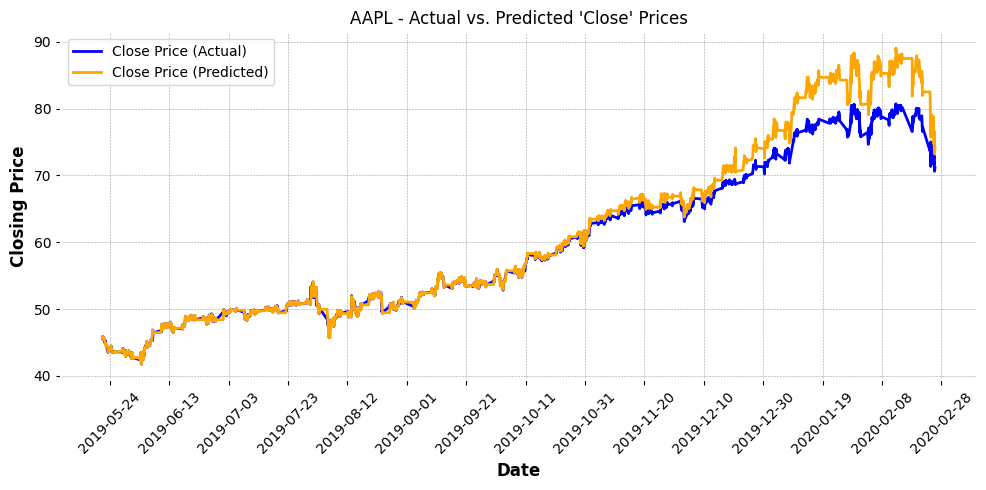

In [ ]:
plot_actual_vs_predicted(pred_df_dict)

#### Predictions on Test Data <a id="predictions-on-test-data"></a>
Let us new check on the test set.

In [ ]:
def test_model(model, test_loader):
    """
    Test function
    
    Parameters:
    - model (LSTM): Trained LSTM model.
    - test_loader (DataLoader): Test data loader.
    
    Returns:
    - tuple: Predicted values and test losses.
    """
    # Transfer the model to the device and set to evaluation mode
    model = model.to(device)
    model.eval()

    # Define the loss function
    criterion = nn.MSELoss()

    # Lists to store the test losses and predictions
    test_losses = []
    predictions = []

    # Using tqdm for the test loop to display a progress bar
    pbar = tqdm(test_loader, total=len(test_loader), leave=False)

    with torch.no_grad(): # Ensure no gradients are computed
        for _, batch in enumerate(pbar):
            # Transfer sequences and labels to device
            X_batch, Y_batch = batch[0].to(device), batch[1].to(device)
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            test_losses.append(loss.item())
            
            # Collect the predictions (move them to CPU for further analysis)
            batch_predictions = outputs.cpu().numpy().flatten()  # Flatten here
            predictions.extend(batch_predictions)
            
            # Update progress bar
            pbar.set_postfix(test_loss=loss.item())

    avg_test_loss = sum(test_losses) / len(test_loader.dataset)
    print(f'Average Test Loss: {avg_test_loss}')

    return predictions, test_losses

In [ ]:
Y_test_pred, test_losses = test_model(trained_model, test_loader)

Average Test Loss: 0.006297872204684115


Descaling the predictions and targets to their original scale.

In [ ]:
Y_test_descaled = descale_data(scaled_data=Y_test, stock=stocks[0])
Y_test_pred_descaled = descale_data(scaled_data=Y_test_pred, stock=stocks[0])

In [ ]:
print(Y_test_descaled.flatten())
print(Y_test_pred_descaled.flatten())

[ 69.8329  69.9143  69.828  ... 164.38   164.33   164.34  ]
[ 72.11438  72.09522  72.12279 ... 250.2761  250.37965 250.27722]


Creating Dataframe of Test Predictions

In [ ]:
pred_df_dict_test = create_pred_df_dict(test_df_dict, Y_test_descaled, Y_test_pred_descaled)
print(f"'{stocks[0]}': {predict} (Actual) vs. {predict} (Predicted) on Test Set:")
pred_df_dict_test[stocks[0]]

'AAPL': Close (Actual) vs. Close (Predicted) on Test Set:


,DateTime,Close (Actual),Close (Predicted)
2328957,2020-02-26 04:06:00,69.832901,72.114380
2328958,2020-02-26 04:07:00,69.914299,72.095222
2328959,2020-02-26 04:10:00,69.828003,72.122787
2328960,2020-02-26 04:11:00,69.544403,72.056747
2328961,2020-02-26 04:12:00,69.438301,71.771111
...,...,...,...
2743498,2022-02-25 19:54:00,164.309998,250.237457
2743499,2022-02-25 19:55:00,164.319992,250.262909
2743500,2022-02-25 19:57:00,164.380005,250.276093
2743501,2022-02-25 19:58:00,164.330002,250.379654


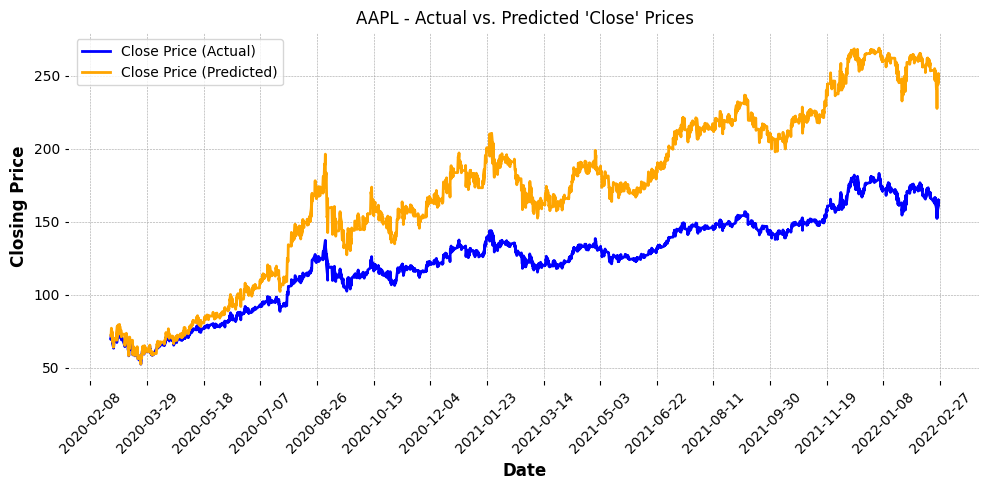

In [ ]:
plot_actual_vs_predicted(pred_df_dict_test)

### References:
1. https://www.kaggle.com/datasets/camnugent/sandp500 <a id="ref1"></a>
2. https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm <a id="ref2"></a>
3. https://www.geeksforgeeks.org/how-to-convert-datetime-to-date-in-pandas/ <a id="ref3"></a>
4. https://coderzcolumn.com/tutorials/data-science/candlestick-chart-in-python-mplfinance-plotly-bokeh <a id="ref4"></a>
5. https://itadviser.dev/stock-market-data-normalization-for-time-series/#:~:text=Z%2Dscore%20normalization%2C%20also%20known,a%20standard%20deviation%20of%201.&text=Where%3A,Z%2Dscore%20(normalized%20value) <a id="ref5"></a>
6. https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/ <a id="ref6"></a>
7. https://www.kaggle.com/code/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch <a id="ref7"></a>
8. https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html <a id="ref8"></a>
9. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html <a id="ref9"></a>
10. OpenAI. (2023). ChatGPT (August 3 Version) [Large language model]. https://chat.openai.com
11. https://www.youtube.com/watch?v=q_HS4s1L8UI
 